In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, average_precision_score, confusion_matrix, classification_report
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================================================
# Project: Next-year financial distress prediction (firm-year panel)
# Data Science Lifecycle focus in this cell:
#   - Setup & configuration (temporal split conventions, leakage control parameters)
#   - Panel integrity (types, deduplication, stable firm identifier)
#   - Define label_year used consistently for splitting and target alignment
# =============================================================================

# ----------------------------
# Configuration (split & preprocessing parameters)
# ----------------------------
FILE_NAME = "../data.csv"

TRAIN_CUTOFF_LABEL_YEAR = 2022   # label_year <= cutoff → train/val pool; after cutoff → test
VAL_YEARS = 1                    # last N years within the pool are validation
N_SPLITS_TIME_CV = 4             # rolling time-based folds for sanity checks

WINSOR_LOWER_Q = 0.01            # winsorization lower quantile (train-only)
WINSOR_UPPER_Q = 0.99            # winsorization upper quantile (train-only)

REQUIRED_KEYS = ["gvkey", "fyear"]
TARGET_COL = "target_next_year_distress"


# ----------------------------
# Utilities (robust numeric ops for ratios)
# ----------------------------

def to_float_numpy(x) -> np.ndarray:
    """Convert series/array-like to float numpy array, coercing non-numeric to NaN."""
    s = pd.to_numeric(x, errors="coerce")
    return s.to_numpy(dtype=float) if hasattr(s, "to_numpy") else np.asarray(s, dtype=float)
def safe_divide(a, b) -> np.ndarray:
    """Elementwise divide a/b with NaN when division is invalid (0 or non-finite)."""
    a = to_float_numpy(a)
    b = to_float_numpy(b)
    out = np.full_like(a, np.nan, dtype=float)
    np.divide(a, b, out=out, where=(b != 0) & np.isfinite(a) & np.isfinite(b))
    return out

def rolling_year_folds(
    df_in: pd.DataFrame, year_col: str = "label_year", n_splits: int = 4, min_train_years: int = 3
) -> list[tuple[np.ndarray, np.ndarray, np.ndarray, int]]:
    """
    Create expanding-window time folds:
      train years: first (min_train_years + k) years
      val year:    next year
    Returns: list of (train_idx, val_idx, train_years, val_year)
    """
    years_sorted = np.sort(df_in[year_col].dropna().unique())
    if len(years_sorted) <= min_train_years:
        return []
    n_splits = min(n_splits, len(years_sorted) - min_train_years)

    folds_out = []
    for k in range(n_splits):
        train_years = years_sorted[: min_train_years + k]
        val_year = int(years_sorted[min_train_years + k])

        train_idx = df_in.index[df_in[year_col].isin(train_years)].to_numpy()
        val_idx = df_in.index[df_in[year_col] == val_year].to_numpy()
        folds_out.append((train_idx, val_idx, train_years, val_year))

    return folds_out


# =============================================================================
# 1) Data acquisition & panel hygiene
# =============================================================================
df = pd.read_csv(FILE_NAME, low_memory=False)

# Convert datadate if present
if "datadate" in df.columns:
    df["datadate"] = pd.to_datetime(df["datadate"], errors="coerce")

# Create stable firm id + de-duplicate firm-year (keep last record)
df["firm_id"] = df["gvkey"]
df = (
    df.sort_values(["firm_id", "fyear"])
      .drop_duplicates(subset=["firm_id", "fyear"], keep="last")
      .reset_index(drop=True)
)

# Label year: predict distress in the next fiscal year
df["label_year"] = df["fyear"] + 1

# =============================================================================
# 2) Split scaffolding (define train/val pool years via label_year)
# =============================================================================
pool_mask = df["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR
pool_years = np.sort(df.loc[pool_mask, "label_year"].dropna().unique())
val_years = pool_years[-VAL_YEARS:] if len(pool_years) else np.array([], dtype=int)

# This mask is ONLY used for imputations (train-only information)
train_mask_for_imputation = pool_mask & (~df["label_year"].isin(val_years))


In [19]:
# =============================================================================
# Data Cleaning & Missing-Data Handling (leakage-aware)
# Purpose:
#   - Quantify missingness and distribution properties before intervention
#   - Preserve informative missingness via miss_* indicators
#   - Impute financial statement inputs using TRAIN-only information:
#       (1) within-firm past values (lag-1) where economically sensible
#       (2) peer medians by year×size_decile on size-scaled ratios (ratio space)
#       (3) KNN imputation (TRAIN-fit) for selected core balance-sheet items
#   - Re-run EDA after imputation to audit how strongly imputations alter the data
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

RAW_INPUTS_FOR_FE = [
    "aco","act","ao","aoloch","ap","apalch","aqc","at","caps","capx","ceq","che","chech","csho","cstk","cstke",
    "datadate","dlc","dlcch","dltis","dltr","dltt","do","dp","dpc","dv","dvc","dvp","dvt","esubc","exre",
    "fiao","fincf","fopo","fyear","gvkey","ib","ibadj","ibc","intan","invch","invt","ismod","ivaco","ivaeq",
    "ivao","ivch","ivncf","ivstch","lco","lct","lt","mibt","mkvalt","niadj","nopi","oancf","oibdp","ppent",
    "prcc_c","prcc_f","prstkc","pstk","pstkn","pstkr","re","recch","rect","seq","siv","spi","sppe","sppiv",
    "sstk","tstk","txach","txbcof","txdc","txditc","txp","txt","xi","xido","xidoc","xint",
    # optional identifiers present in many extracts:
    "conm","consol","datafmt","indfmt",
]
raw = [c for c in RAW_INPUTS_FOR_FE if c in df.columns]

# ---------------------------------------------------------------------------
# 3.0 Ensure keys exist + types
# ---------------------------------------------------------------------------
if "firm_id" not in df.columns:
    if "gvkey" in df.columns:
        df["firm_id"] = df["gvkey"]
    else:
        raise ValueError("Need either firm_id or gvkey in df to run panel imputations.")

if "fyear" in df.columns:
    df["fyear"] = pd.to_numeric(df["fyear"], errors="coerce")

# ---------------------------------------------------------------------------
# 3.1 Drop rows with missing critical identifiers (do not impute these)
# ---------------------------------------------------------------------------
NON_IMPUTE_DROP = [c for c in ["gvkey", "datadate", "fyear", "conm", "datafmt", "indfmt", "consol"] if c in df.columns]
if NON_IMPUTE_DROP:
    before_n = df.shape[0]
    df = df.dropna(subset=NON_IMPUTE_DROP).copy()
    after_n = df.shape[0]
    if after_n < before_n:
        print(f"[INFO] Dropped {before_n - after_n:,} rows due to missing non-imputable ID/meta fields: {NON_IMPUTE_DROP}")

# Ensure train mask aligns after drops
if isinstance(train_mask_for_imputation, pd.Series):
    train_mask_for_imputation = train_mask_for_imputation.reindex(df.index).fillna(False).astype(bool)

# Rebuild raw after potential drop
raw = [c for c in RAW_INPUTS_FOR_FE if c in df.columns]

# ---------------------------------------------------------------------------
# 3.2 EDA BEFORE imputation (missingness + distribution snapshot)
# ---------------------------------------------------------------------------
df_raw_pre = df[raw].copy(deep=True)

pre_miss = pd.DataFrame(
    {
        "col": raw,
        "n": [int(df_raw_pre[c].shape[0]) for c in raw],
        "n_na_pre": [int(df_raw_pre[c].isna().sum()) for c in raw],
        "pct_na_pre": [float(df_raw_pre[c].isna().mean() * 100.0) for c in raw],
        "train_n": [int(train_mask_for_imputation.sum()) for _ in raw],
        "train_pct_na_pre": [
            float(df_raw_pre.loc[train_mask_for_imputation, c].isna().mean() * 100.0) for c in raw
        ],
    }
).sort_values("pct_na_pre", ascending=False)

print("\n=== EDA (BEFORE imputation): Missingness on raw inputs ===")
print(pre_miss.round(4).head(50))

# Numeric distribution summary (coerce non-numeric to NaN)
if raw:
    x_pre = df_raw_pre[raw].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    q_pre = x_pre.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
    pre_dist = pd.DataFrame(
        {
            "n_nonmiss_pre": x_pre.notna().sum(),
            "mean_pre": x_pre.mean(),
            "std_pre": x_pre.std(ddof=0),
            "min_pre": x_pre.min(),
            "p01_pre": q_pre[0.01],
            "p05_pre": q_pre[0.05],
            "p25_pre": q_pre[0.25],
            "p50_pre": q_pre[0.50],
            "p75_pre": q_pre[0.75],
            "p95_pre": q_pre[0.95],
            "p99_pre": q_pre[0.99],
            "max_pre": x_pre.max(),
        }
    )
    print("\n=== EDA (BEFORE imputation): Distribution summary (raw inputs) ===")
    print(pre_dist.round(4).sort_values("n_nonmiss_pre", ascending=True).head(50))

# ---------------------------------------------------------------------------
# 3.3 Missingness flags (ALWAYS create before imputations)
# ---------------------------------------------------------------------------
for c in raw:
    df[f"miss_{c}"] = df[c].isna().astype("int8")

# Helper: originally-observed indicator
def _obs(col: str) -> pd.Series:
    m = f"miss_{col}"
    if m in df.columns:
        return (df[m] == 0)
    return df[col].notna()

# ---------------------------------------------------------------------------
# 3.4 Grouping key for peer-based imputations (no industry used)
#   - Use TRAIN-derived size_decile to avoid mixing microcaps with mega-caps
# ---------------------------------------------------------------------------
df = df.sort_values(["firm_id", "fyear"]).copy()

# TRAIN-derived size deciles on log(at) using observed TRAIN values only
if "at" in df.columns:
    at_train = pd.to_numeric(df.loc[train_mask_for_imputation, "at"], errors="coerce")
    log_at_train = np.log(at_train.where(at_train > 0))
    qs = np.linspace(0, 1, 11)
    edges = np.unique(np.nanquantile(log_at_train.dropna(), qs))
    if edges.size >= 3:
        log_at_all = np.log(pd.to_numeric(df["at"], errors="coerce").where(pd.to_numeric(df["at"], errors="coerce") > 0))
        df["size_decile"] = pd.cut(log_at_all, bins=edges, include_lowest=True, labels=False)
    else:
        df["size_decile"] = np.nan
else:
    df["size_decile"] = np.nan

group_cols = ["fyear", "size_decile"]

# ---------------------------------------------------------------------------
# 3.5 Step 1: Construct / reconcile FIRST (no leakage: contemporaneous or lag only)
# ---------------------------------------------------------------------------
# 3.5.1 Mild lag-1 fill for prices, then mkvalt = prcc_f * csho if missing
for px in ["prcc_f", "prcc_c"]:
    if px in df.columns:
        df[px] = df[px].where(df[px].notna(), df.groupby("firm_id")[px].shift(1))

if all(c in df.columns for c in ["mkvalt", "prcc_f", "csho"]):
    mkvalt_miss = df["mkvalt"].isna()
    mkvalt_calc = pd.to_numeric(df["prcc_f"], errors="coerce") * pd.to_numeric(df["csho"], errors="coerce")
    df.loc[mkvalt_miss & mkvalt_calc.notna(), "mkvalt"] = mkvalt_calc.loc[mkvalt_miss & mkvalt_calc.notna()]

# 3.5.2 Reconstruct change variables from level differences (fill only if change var is missing)
def _fill_change_from_levels(change_col, level_col):
    if change_col in df.columns and level_col in df.columns:
        miss = df[change_col].isna()
        lvl = pd.to_numeric(df[level_col], errors="coerce")
        lag_lvl = pd.to_numeric(df.groupby("firm_id")[level_col].shift(1), errors="coerce")
        recon = lvl - lag_lvl
        df.loc[miss & recon.notna(), change_col] = recon.loc[miss & recon.notna()]

_fill_change_from_levels("dlcch", "dlc")
_fill_change_from_levels("recch", "rect")
_fill_change_from_levels("invch", "invt")
_fill_change_from_levels("chech", "che")

# ---------------------------------------------------------------------------
# 3.6 Sparse zero-fill for structurally zero-inflated items (TRAIN-validated)
#   - Keeps miss_* as informative signal
# ---------------------------------------------------------------------------
SPARSE_CANDIDATES = [c for c in [
    "txach","txdc","txbcof","spi","siv","sppiv","ivstch","sppe","esubc","dvp","dv","dvc","dvt"
] if c in df.columns]

def _zero_fill_if_sparse(col: str, zero_share_thresh: float = 0.70, min_obs: int = 1000) -> bool:
    mflag = f"miss_{col}"
    if mflag not in df.columns:
        return False
    obs_mask = train_mask_for_imputation & (df[mflag] == 0)
    s = pd.to_numeric(df.loc[obs_mask, col], errors="coerce").replace([np.inf, -np.inf], np.nan)
    if s.notna().sum() < min_obs:
        return False
    zero_share = float((s == 0).mean())
    med = float(s.median()) if s.notna().any() else np.nan
    if np.isfinite(med) and (med == 0.0) and (zero_share >= zero_share_thresh):
        df.loc[df[col].isna(), col] = 0.0
        return True
    return False

for c in SPARSE_CANDIDATES:
    _zero_fill_if_sparse(c)

# Explicit “tax components -> 0” rule (FFO proxy safety)
for c in ["txt", "txdc", "txach"]:
    if c in df.columns:
        df.loc[df[c].isna(), c] = 0.0

# ---------------------------------------------------------------------------
# 3.7 Step 3: Stocks — lag-1 fill -> peer median of ratio (x/at) with ratio-space clipping
# ---------------------------------------------------------------------------
STOCKS = [c for c in [
    "aco","act","ao","ap","at","caps","ceq","che","csho","cstk","dlc","dltt","intan","invt","lco","lct","lt",
    "mibt","ppent","pstk","pstkn","pstkr","re","rect","seq","tstk","ivaeq","mkvalt"
] if c in df.columns]

# lag-1 fill (past-only)
if STOCKS:
    lag1 = df.groupby("firm_id")[STOCKS].shift(1)
    df[STOCKS] = df[STOCKS].where(df[STOCKS].notna(), lag1)

# non-negativity only where economically necessary
NONNEG_STOCKS = set([c for c in STOCKS if c in {
    "aco","act","ao","ap","at","caps","che","csho","cstk","dlc","dltt","intan","invt","lco","lct","lt",
    "mibt","mkvalt","ppent","pstk","pstkn","pstkr","rect","tstk","ivaeq"
}])

def _fit_ratio_stats(train_df: pd.DataFrame, col: str, base: str = "at", qlo=0.01, qhi=0.99):
    mcol = f"miss_{col}"
    mbase = f"miss_{base}"
    s = pd.to_numeric(train_df[col], errors="coerce")
    b = pd.to_numeric(train_df[base], errors="coerce") if base in train_df.columns else None

    obs_s = (train_df[mcol] == 0) if mcol in train_df.columns else s.notna()

    if b is None:
        tr = train_df.loc[obs_s, group_cols + [col]].copy()
        tr[col] = pd.to_numeric(tr[col], errors="coerce").replace([np.inf, -np.inf], np.nan)
        grp = tr.groupby(group_cols)[col].median()
        overall = float(tr[col].median()) if tr[col].notna().any() else 0.0
        return ("level", overall, grp, np.nan, np.nan)

    obs_b = (train_df[mbase] == 0) if mbase in train_df.columns else b.notna()
    valid = obs_s & obs_b & s.notna() & b.notna() & (b > 0)

    if valid.sum() < 200:
        tr = train_df.loc[obs_s, group_cols + [col]].copy()
        tr[col] = pd.to_numeric(tr[col], errors="coerce").replace([np.inf, -np.inf], np.nan)
        grp = tr.groupby(group_cols)[col].median()
        overall = float(tr[col].median()) if tr[col].notna().any() else 0.0
        return ("level", overall, grp, np.nan, np.nan)

    ratio = (s[valid] / b[valid]).replace([np.inf, -np.inf], np.nan).dropna()
    overall = float(ratio.median()) if ratio.notna().any() else 0.0
    r_lo = float(ratio.quantile(qlo))
    r_hi = float(ratio.quantile(qhi))

    tmp = train_df.loc[valid, group_cols].copy()
    tmp["_ratio_"] = ratio.values
    grp = tmp.groupby(group_cols)["_ratio_"].median()
    return ("ratio", overall, grp, r_lo, r_hi)

def _apply_ratio_stats(df_all: pd.DataFrame, col: str, fit_obj, base: str = "at", nonneg: bool = False):
    kind, overall, grp, r_lo, r_hi = fit_obj
    miss = df_all[col].isna()
    if not miss.any():
        return

    if kind == "ratio" and base in df_all.columns:
        b = pd.to_numeric(df_all.loc[miss, base], errors="coerce")
        g = df_all.loc[miss, group_cols]

        if len(group_cols) == 1:
            mapped = g[group_cols[0]].map(grp)
        else:
            keys = list(map(tuple, g[group_cols].to_numpy()))
            mapped = pd.Series(keys, index=g.index).map(grp)

        r = pd.to_numeric(mapped, errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(overall)

        # clip in ratio space (TRAIN-observed band)
        if np.isfinite(r_lo) and np.isfinite(r_hi) and (r_lo < r_hi):
            r = r.clip(r_lo, r_hi)

        fill = r * b
        fill = fill.where(b.notna() & (b > 0), np.nan)
        df_all.loc[miss & fill.notna(), col] = fill.loc[miss & fill.notna()].to_numpy()

    # fallback: group level medians (TRAIN-fit, observed-only)
    miss2 = df_all[col].isna()
    if miss2.any():
        mflag = f"miss_{col}"
        obs_train_mask = train_mask_for_imputation
        if mflag in df_all.columns:
            obs_train_mask = obs_train_mask & (df_all[mflag] == 0)

        tr = df_all.loc[obs_train_mask, group_cols + [col]].copy()
        tr[col] = pd.to_numeric(tr[col], errors="coerce").replace([np.inf, -np.inf], np.nan)

        lvl_overall = float(tr[col].median()) if tr[col].notna().any() else 0.0
        lvl_grp = tr.groupby(group_cols)[col].median()

        g2 = df_all.loc[miss2, group_cols]
        if len(group_cols) == 1:
            mapped2 = g2[group_cols[0]].map(lvl_grp)
        else:
            keys2 = list(map(tuple, g2[group_cols].to_numpy()))
            mapped2 = pd.Series(keys2, index=g2.index).map(lvl_grp)

        fill2 = pd.to_numeric(mapped2, errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(lvl_overall)
        if nonneg:
            fill2 = fill2.clip(lower=0.0)
        df_all.loc[miss2, col] = fill2.to_numpy()

# Fit on training
tr_all = df.loc[train_mask_for_imputation].copy()
stock_fits = {c: _fit_ratio_stats(tr_all, c, base="at") for c in STOCKS}

# Apply to full df
for c in STOCKS:
    _apply_ratio_stats(df, c, stock_fits[c], base="at", nonneg=(c in NONNEG_STOCKS))

# ---------------------------------------------------------------------------
# 3.8 Step 4: Flows / income variables — ratio-median imputation (leakage-aware)
# ---------------------------------------------------------------------------
FLOWS = [c for c in ["ib","ibadj","ibc","niadj","nopi","oibdp","dp","oancf","fincf","ivncf","xint"] if c in df.columns]

# Debt-aware base for xint
if "xint" in df.columns and all(c in df.columns for c in ["dlc", "dltt"]):
    df["_td_for_xint"] = (
        pd.to_numeric(df["dlc"], errors="coerce").fillna(0.0)
        + pd.to_numeric(df["dltt"], errors="coerce").fillna(0.0)
    )
else:
    df["_td_for_xint"] = np.nan

# If total debt <= 0 and xint missing -> 0
if "xint" in df.columns and "_td_for_xint" in df.columns:
    td = pd.to_numeric(df["_td_for_xint"], errors="coerce").fillna(0.0)
    df.loc[df["xint"].isna() & (td <= 0), "xint"] = 0.0

flow_fits = {}
for c in FLOWS:
    base = "_td_for_xint" if (c == "xint" and "_td_for_xint" in df.columns) else "at"
    flow_fits[c] = _fit_ratio_stats(tr_all, c, base=base)

for c in FLOWS:
    base = "_td_for_xint" if (c == "xint" and "_td_for_xint" in df.columns) else "at"
    _apply_ratio_stats(df, c, flow_fits[c], base=base, nonneg=False)

# ---------------------------------------------------------------------------
# 3.9 KNN imputation (TRAIN-fit) for selected core balance-sheet items
#   - Applies ONLY to originally-missing rows (miss_* == 1)
#   - Uses a robust signed-log transform for magnitudes
# ---------------------------------------------------------------------------
KNN_TARGETS = [c for c in [
    "at","act","lct","lt","seq","dlc","dltt","che","ppent","rect","invt","re","ceq","caps"
] if c in df.columns]

# Non-negativity for clearly non-negative magnitudes (do NOT force seq/ceq/re to be non-negative)
KNN_NONNEG = set([c for c in KNN_TARGETS if c in {"at","act","lct","lt","dlc","dltt","che","ppent","rect","invt","caps"}])

if KNN_TARGETS:
    # KNN feature set (kept compact and available in your raw inputs)
    knn_feats = []
    for c in ["fyear", "size_decile", "mkvalt", "csho", "prcc_f", "prcc_c"]:
        if c in df.columns:
            knn_feats.append(c)
    knn_feats = list(dict.fromkeys(knn_feats))  # preserve order, unique

    knn_cols = list(dict.fromkeys(knn_feats + KNN_TARGETS))
    X = df[knn_cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

    # For KNN, re-instate NaN only for the targets that were originally missing
    for t in KNN_TARGETS:
        mflag = f"miss_{t}"
        if mflag in df.columns:
            X.loc[df[mflag] == 1, t] = np.nan

    # Fill size_decile NaN with TRAIN median decile for distance stability
    if "size_decile" in X.columns:
        sd_train = X.loc[train_mask_for_imputation, "size_decile"]
        sd_fill = float(sd_train.median()) if sd_train.notna().any() else 5.0
        X["size_decile"] = X["size_decile"].fillna(sd_fill)

    # Robust transform: signed log1p for magnitudes; keep fyear/size_decile in levels
    def _signed_log1p(a: pd.Series) -> pd.Series:
        v = pd.to_numeric(a, errors="coerce")
        return np.sign(v) * np.log1p(np.abs(v))

    Z = X.copy()
    for c in Z.columns:
        if c not in {"fyear", "size_decile"}:
            Z[c] = _signed_log1p(Z[c])

    # Standardize using TRAIN-only stats (nan-safe)
    mu = Z.loc[train_mask_for_imputation].mean(skipna=True)
    sd = Z.loc[train_mask_for_imputation].std(skipna=True, ddof=0).replace(0.0, 1.0)
    sd = sd.fillna(1.0)
    mu = mu.fillna(0.0)

    Zs = (Z - mu) / sd

    # Fit KNN on TRAIN only; transform all rows
    imputer = KNNImputer(n_neighbors=25, weights="distance", metric="nan_euclidean")
    imputer.fit(Zs.loc[train_mask_for_imputation].to_numpy(dtype=float))
    Zs_imp = imputer.transform(Zs.to_numpy(dtype=float))
    Zs_imp = pd.DataFrame(Zs_imp, index=Zs.index, columns=Zs.columns)

    # Unscale
    Z_imp = Zs_imp * sd + mu

    # Invert signed log for magnitudes
    X_imp = X.copy()
    for c in Z_imp.columns:
        if c in {"fyear", "size_decile"}:
            X_imp[c] = Z_imp[c]
        else:
            v = pd.to_numeric(Z_imp[c], errors="coerce")
            X_imp[c] = np.sign(v) * (np.expm1(np.abs(v)))

    # Write back ONLY for originally-missing targets
    for t in KNN_TARGETS:
        mflag = f"miss_{t}"
        if mflag in df.columns:
            miss_mask = (df[mflag] == 1)
            df.loc[miss_mask, t] = pd.to_numeric(X_imp.loc[miss_mask, t], errors="coerce").to_numpy()

            if t in KNN_NONNEG:
                df.loc[miss_mask, t] = pd.to_numeric(df.loc[miss_mask, t], errors="coerce").clip(lower=0.0)

# ---------------------------------------------------------------------------
# 3.10 Change variables AFTER level imputations:
#   - Fill only if change is missing
#   - Reconstruct only when both levels were originally observed; otherwise impute change directly
# ---------------------------------------------------------------------------
def _fill_change_after_levels(change_col, level_col):
    if change_col in df.columns and level_col in df.columns:
        lvl = pd.to_numeric(df[level_col], errors="coerce")
        lag_lvl = pd.to_numeric(df.groupby("firm_id")[level_col].shift(1), errors="coerce")
        recon = lvl - lag_lvl

        miss_now = df[change_col].isna()

        # only reconstruct when both levels were originally observed
        obs_now = _obs(level_col)
        obs_lag = obs_now.groupby(df["firm_id"]).shift(1).fillna(False)
        can_recon = miss_now & obs_now & obs_lag & recon.notna()
        df.loc[can_recon, change_col] = recon.loc[can_recon]

        # remaining missing: direct group-median impute of change (TRAIN-fit, observed-only if possible)
        miss2 = df[change_col].isna()
        if miss2.any():
            mflag = f"miss_{change_col}"
            obs_train = train_mask_for_imputation
            if mflag in df.columns:
                obs_train = obs_train & (df[mflag] == 0)

            tr = df.loc[obs_train, group_cols + [change_col]].copy()
            tr[change_col] = pd.to_numeric(tr[change_col], errors="coerce").replace([np.inf, -np.inf], np.nan)
            overall = float(tr[change_col].median()) if tr[change_col].notna().any() else 0.0
            grp = tr.groupby(group_cols)[change_col].median()

            g = df.loc[miss2, group_cols]
            if len(group_cols) == 1:
                mapped = g[group_cols[0]].map(grp)
            else:
                keys = list(map(tuple, g[group_cols].to_numpy()))
                mapped = pd.Series(keys, index=g.index).map(grp)

            fill = pd.to_numeric(mapped, errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(overall)
            df.loc[miss2, change_col] = fill.to_numpy()

_fill_change_after_levels("dlcch", "dlc")
_fill_change_after_levels("recch", "rect")
_fill_change_after_levels("invch", "invt")
_fill_change_after_levels("chech", "che")
if "apalch" in df.columns and "ap" in df.columns:
    _fill_change_after_levels("apalch", "ap")

# ---------------------------------------------------------------------------
# 3.11 Guardrail: cap ONLY-imputed values (miss_* == 1) to TRAIN-observed quantile band
# ---------------------------------------------------------------------------
REG_NONNEG = set(["at","act","lct","lt","dlc","dltt","che","ppent","rect","invt","caps"])  # for this script

def _cap_imputed_to_train_quantiles(
    df_all: pd.DataFrame,
    col: str,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    nonneg: bool = False,
) -> None:
    flag = f"miss_{col}"
    if col not in df_all.columns or flag not in df_all.columns:
        return

    miss_mask = df_all[flag].astype(bool)
    if not miss_mask.any():
        return

    # bounds from TRAIN & originally-observed values
    obs = pd.to_numeric(df_all.loc[train_mask_for_imputation & (~miss_mask), col], errors="coerce").replace(
        [np.inf, -np.inf], np.nan
    )
    if obs.notna().sum() < 200:
        obs = pd.to_numeric(df_all.loc[train_mask_for_imputation, col], errors="coerce").replace([np.inf, -np.inf], np.nan)

    if obs.notna().sum() == 0:
        return

    lo = float(obs.quantile(lower_q))
    hi = float(obs.quantile(upper_q))

    if nonneg:
        lo = max(0.0, lo) if np.isfinite(lo) else 0.0

    s = pd.to_numeric(df_all.loc[miss_mask, col], errors="coerce").replace([np.inf, -np.inf], np.nan)
    s = s.clip(lo, hi)
    if nonneg:
        s = s.clip(lower=0.0)
    df_all.loc[miss_mask, col] = s.to_numpy()

CAP_COLS = sorted(
    (
        set(STOCKS + FLOWS + ["dlcch", "apalch", "recch", "invch", "chech"])
        | set(KNN_TARGETS)
    ) & set(df.columns)
)

for c in CAP_COLS:
    _cap_imputed_to_train_quantiles(
        df,
        c,
        lower_q=0.01,
        upper_q=0.99,
        nonneg=(c in NONNEG_STOCKS) or (c in REG_NONNEG),
    )

# ---------------------------------------------------------------------------
# 3.12 EDA AFTER imputation (missingness reduction + distribution deltas)
# ---------------------------------------------------------------------------
df_raw_post = df[raw].copy(deep=True)

post_miss = pd.DataFrame(
    {
        "col": raw,
        "n_na_post": [int(df_raw_post[c].isna().sum()) for c in raw],
        "pct_na_post": [float(df_raw_post[c].isna().mean() * 100.0) for c in raw],
        "train_pct_na_post": [
            float(df_raw_post.loc[train_mask_for_imputation, c].isna().mean() * 100.0) for c in raw
        ],
    }
)

changes = pre_miss.merge(post_miss, on="col", how="left")
changes["n_imputed"] = changes["n_na_pre"] - changes["n_na_post"]
changes["pct_points_na_reduction"] = changes["pct_na_pre"] - changes["pct_na_post"]

x_post = df_raw_post[raw].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
q_post = x_post.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
post_dist = pd.DataFrame(
    {
        "n_nonmiss_post": x_post.notna().sum(),
        "mean_post": x_post.mean(),
        "std_post": x_post.std(ddof=0),
        "min_post": x_post.min(),
        "p01_post": q_post[0.01],
        "p05_post": q_post[0.05],
        "p25_post": q_post[0.25],
        "p50_post": q_post[0.50],
        "p75_post": q_post[0.75],
        "p95_post": q_post[0.95],
        "p99_post": q_post[0.99],
        "max_post": x_post.max(),
    }
)

pre_dist_key = pre_dist[["n_nonmiss_pre","mean_pre","std_pre","p01_pre","p50_pre","p99_pre"]].copy() if raw else pd.DataFrame()
post_dist_key = post_dist[["n_nonmiss_post","mean_post","std_post","p01_post","p50_post","p99_post"]].copy() if raw else pd.DataFrame()

dist_delta = pre_dist_key.join(post_dist_key, how="outer")
dist_delta["delta_mean"] = dist_delta["mean_post"] - dist_delta["mean_pre"]
dist_delta["delta_std"]  = dist_delta["std_post"]  - dist_delta["std_pre"]
dist_delta["delta_p50"]  = dist_delta["p50_post"]  - dist_delta["p50_pre"]

# Imputed-only diagnostics (based on original missingness in df_raw_pre)
rows = []
for c in raw:
    pre_na_mask = df_raw_pre[c].isna()
    n_imp = int(pre_na_mask.sum())
    if n_imp == 0:
        rows.append((c, 0, np.nan, np.nan, np.nan, np.nan, np.nan))
        continue

    imp_vals = pd.to_numeric(df_raw_post.loc[pre_na_mask, c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    obs_vals = pd.to_numeric(df_raw_pre.loc[~pre_na_mask, c], errors="coerce").replace([np.inf, -np.inf], np.nan)

    rows.append(
        (
            c,
            n_imp,
            float(imp_vals.mean()) if imp_vals.notna().any() else np.nan,
            float(imp_vals.median()) if imp_vals.notna().any() else np.nan,
            float(imp_vals.std(ddof=0)) if imp_vals.notna().any() else np.nan,
            float(obs_vals.mean()) if obs_vals.notna().any() else np.nan,
            float(obs_vals.median()) if obs_vals.notna().any() else np.nan,
        )
    )

imputed_only = pd.DataFrame(
    rows,
    columns=["col","n_imputed","imputed_mean","imputed_median","imputed_std","observed_mean_pre","observed_median_pre"],
).set_index("col")

print("\n=== EDA (AFTER imputation): Missingness on raw inputs + change ===")
cols_show = [
    "col", "n", "n_na_pre", "pct_na_pre", "n_na_post", "pct_na_post",
    "n_imputed", "pct_points_na_reduction", "train_pct_na_pre", "train_pct_na_post",
]
print(
    changes[cols_show]
    .sort_values(["n_imputed","pct_points_na_reduction"], ascending=[False, False])
    .round(4)
    .head(50)
)

print("\n=== Change analysis: Distribution deltas (post - pre) on raw inputs ===")
print(
    dist_delta[["n_nonmiss_pre","n_nonmiss_post","delta_mean","delta_std","delta_p50"]]
    .sort_values("delta_mean", key=lambda s: s.abs(), ascending=False)
    .round(6)
    .head(50)
)

print("\n=== Change analysis: Imputed-only vs observed (pre) summary ===")
print(
    imputed_only.assign(
        mean_gap_imputed_minus_observed=lambda d: d["imputed_mean"] - d["observed_mean_pre"],
        median_gap_imputed_minus_observed=lambda d: d["imputed_median"] - d["observed_median_pre"],
    )
    .sort_values("n_imputed", ascending=False)
    .round(6)
    .head(50)
)



=== EDA (BEFORE imputation): Missingness on raw inputs ===
       col      n  n_na_pre  pct_na_pre  train_n  train_pct_na_pre
18   dlcch  75005     33143     44.1877    48458           42.9630
5   apalch  75005     30371     40.4920    48458           39.0214
75   txach  75005     22791     30.3860    48458           29.2501
48  ivstch  75005     19194     25.5903    48458           23.0282
66   recch  75005     12589     16.7842    48458           16.5938
53  mkvalt  75005     12350     16.4656    48458           17.0189
71    sppe  75005     12239     16.3176    48458           16.4307
1      act  75005     10721     14.2937    48458           14.6581
50     lct  75005     10695     14.2590    48458           14.5982
84    xint  75005     10536     14.0471    48458           13.9234
78  txditc  75005      9069     12.0912    48458           12.2044
79     txp  75005      7942     10.5886    48458           10.6917
29   esubc  75005      6798      9.0634    48458            8.8964
49

/var/folders/p1/_cwwbdbj51q1lwpynfnzdxpm0000gn/T/ipykernel_879/2286657439.py:434: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obs_lag = obs_now.groupby(df["firm_id"]).shift(1).fillna(False)
/var/folders/p1/_cwwbdbj51q1lwpynfnzdxpm0000gn/T/ipykernel_879/2286657439.py:434: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  obs_lag = obs_now.groupby(df["firm_id"]).shift(1).fillna(False)
/var/folders/p1/_cwwbdbj51q1lwpynfnzdxpm0000gn/T/ipykernel_879/2286657439.py:434: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wi


=== EDA (AFTER imputation): Missingness on raw inputs + change ===
       col      n  n_na_pre  pct_na_pre  n_na_post  pct_na_post  n_imputed  \
0    dlcch  75005     33143     44.1877          0       0.0000      33143   
1   apalch  75005     30371     40.4920          0       0.0000      30371   
2    txach  75005     22791     30.3860          0       0.0000      22791   
4    recch  75005     12589     16.7842          0       0.0000      12589   
5   mkvalt  75005     12350     16.4656          0       0.0000      12350   
7      act  75005     10721     14.2937          0       0.0000      10721   
8      lct  75005     10695     14.2590          0       0.0000      10695   
9     xint  75005     10536     14.0471          0       0.0000      10536   
12   esubc  75005      6798      9.0634          0       0.0000       6798   
13     lco  75005      6779      9.0381          0       0.0000       6779   
14     aco  75005      6778      9.0367          0       0.0000       6778

In [20]:
# =============================================================================
# Feature Engineering & Target Construction
#   - Build leverage / coverage / cash-flow-to-debt ratios commonly used in credit analysis
#   - Define a 'highly leveraged' distress proxy from multiple ratio-based conditions
#   - Create the supervised-learning target: next-year distress within the same firm
# =============================================================================

firm_col = "firm_id"

dlc = pd.to_numeric(df.get("dlc", np.nan), errors="coerce")
dltt = pd.to_numeric(df.get("dltt", np.nan), errors="coerce")
df["total_debt"] = pd.concat([dlc, dltt], axis=1).sum(axis=1, min_count=1)

seq = pd.to_numeric(df.get("seq", np.nan), errors="coerce")
mibt = pd.to_numeric(df.get("mibt", 0.0), errors="coerce")
df["equity_plus_mi_sp"] = seq + mibt
df["total_capital_sp"] = df["total_debt"] + df["equity_plus_mi_sp"]

# --- CHANGED (minimal): handle total capital <= 0 as extreme leverage + flag ---
cap_s = pd.to_numeric(df["total_capital_sp"], errors="coerce")
df["cap_nonpos_flag"] = (cap_s.notna() & (cap_s <= 0)).astype("int8")
df["sp_debt_to_capital"] = safe_divide(df["total_debt"], cap_s)
df.loc[df["cap_nonpos_flag"] == 1, "sp_debt_to_capital"] = np.inf
# ---------------------------------------------------------------------------

oibdp = pd.to_numeric(df.get("oibdp", np.nan), errors="coerce")
xint = pd.to_numeric(df.get("xint", np.nan), errors="coerce")

# --- CHANGED (minimal): handle EBITDA <= 0 as extreme leverage + flag ---
df["ebitda_nonpos_flag"] = (oibdp.notna() & (oibdp <= 0)).astype("int8")
df["sp_debt_to_ebitda"] = safe_divide(df["total_debt"], oibdp)
df.loc[df["ebitda_nonpos_flag"] == 1, "sp_debt_to_ebitda"] = np.inf
# ---------------------------------------------------------------------------

# --- OPTIONAL transparency (simple): flag if tax proxy components missing (no complex proxying) ---
txt_raw = pd.to_numeric(df.get("txt", np.nan), errors="coerce")
txdc_raw = pd.to_numeric(df.get("txdc", np.nan), errors="coerce")
txach_raw = pd.to_numeric(df.get("txach", np.nan), errors="coerce")
df["tax_proxy_incomplete"] = (txt_raw.isna() | txdc_raw.isna() | txach_raw.isna()).astype("int8")

txt = txt_raw.fillna(0.0)
txdc = txdc_raw.fillna(0.0)
txach = txach_raw.fillna(0.0)
df["cash_tax_paid_proxy"] = txt - txdc - txach

df["ffo_proxy"] = oibdp - xint - pd.to_numeric(df["cash_tax_paid_proxy"], errors="coerce")
df["sp_ffo_to_debt"] = safe_divide(df["ffo_proxy"], df["total_debt"])

oancf = pd.to_numeric(df.get("oancf", np.nan), errors="coerce")
capx = pd.to_numeric(df.get("capx", np.nan), errors="coerce")
df["sp_cfo_to_debt"] = safe_divide(oancf, df["total_debt"])
df["focf"] = oancf - capx
df["sp_focf_to_debt"] = safe_divide(df["focf"], df["total_debt"])

# --- CHANGED (minimal): make outflows robust to sign conventions ---
dv = pd.to_numeric(df.get("dv", 0.0), errors="coerce").fillna(0.0).abs()
prstkc = pd.to_numeric(df.get("prstkc", 0.0), errors="coerce").fillna(0.0).abs()
df["dcf"] = df["focf"] - dv - prstkc
df["sp_dcf_to_debt"] = safe_divide(df["dcf"], df["total_debt"])
# ------------------------------------------------------------------

# Log transforms (log1p handles 0 nicely). Negative → NaN.
for c in ["at", "mkvalt"]:
    if c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        df[f"log_{c}"] = np.where(s >= 0, np.log1p(s), np.nan)

# Interest coverage: EBITDA / |interest expense|
# Interest coverage can explode when interest expense is near zero.
# Stabilize by flooring the denominator, capping extreme values, and log-transforming.
INT_FLOOR = 1.0  # minimum |interest expense| to avoid blow-ups
IC_CAP = 100.0  # cap extreme coverage magnitudes before log transform
denom_ic = np.maximum(xint.abs(), INT_FLOOR)
df["sp_interest_coverage_raw"] = safe_divide(oibdp, denom_ic)
df["sp_interest_coverage_is_capped"] = (df["sp_interest_coverage_raw"].abs() > IC_CAP).astype("int8")
df["sp_interest_coverage_denom_floored"] = (xint.abs() < INT_FLOOR).astype("int8")
df["sp_interest_coverage"] = np.sign(df["sp_interest_coverage_raw"]) * np.log1p(
    np.minimum(df["sp_interest_coverage_raw"].abs(), IC_CAP)
)

# Distress proxy: 'highly leveraged' condition using multiple credit-ratio thresholds
td = pd.to_numeric(df["total_debt"], errors="coerce").to_numpy(dtype=float)
cap = pd.to_numeric(df["total_capital_sp"], errors="coerce").to_numpy(dtype=float)
eb = pd.to_numeric(oibdp, errors="coerce").to_numpy(dtype=float)
ffo = pd.to_numeric(df["ffo_proxy"], errors="coerce").to_numpy(dtype=float)

ffo_to_debt_pct = 100.0 * safe_divide(ffo, td)

debt_to_capital_pct = 100.0 * safe_divide(td, cap)
# --- CHANGED (minimal): cap <= 0 => extreme leverage (so hl_cap can trigger) ---
debt_to_capital_pct = np.where(np.isfinite(cap) & (cap <= 0), np.inf, debt_to_capital_pct)

debt_to_ebitda = safe_divide(td, eb)
# --- CHANGED (minimal): EBITDA <= 0 => extreme leverage (so hl_deb can trigger) ---
debt_to_ebitda = np.where(np.isfinite(eb) & (eb <= 0), np.inf, debt_to_ebitda)

# Three “highly leveraged” conditions (S&P table)
hl_ffo = (td > 0) & (ffo_to_debt_pct < 15.0)  # FFO/total debt < 15%
hl_cap = (td > 0) & (debt_to_capital_pct > 55.0)  # TD/total capital > 55% (or cap<=0 => inf)
hl_deb = (td > 0) & (debt_to_ebitda > 4.5)  # TD/EBITDA > 4.5 (or EBITDA<=0 => inf)

is_highly_leveraged = hl_ffo & hl_cap & hl_deb

# Equity strictly negative and not missing
# --- CHANGED (minimal): use standard negative equity cutoff and actually use it ---
is_equity_negative = seq.notna() & (seq < 0)

# Final distress rule: highly leveraged OR negative equity (simple, avoids computed-but-unused flag)
df["distress_dummy"] = (is_highly_leveraged | is_equity_negative.to_numpy(dtype=bool)).astype("int8")
# ------------------------------------------------------------------------------

# Target: next year's distress (within firm)
df["target_next_year_distress"] = (
    df.groupby(firm_col)["distress_dummy"].shift(-1)
)

# Indicator for whether the next-year label is observed (attrition / survivorship considerations)
df["has_next_year_obs"] = df["target_next_year_distress"].notna().astype("int8")
n_total = len(df)
n_missing_next = int((df["has_next_year_obs"] == 0).sum())
print(
    f"Next-year label availability: {n_total - n_missing_next:,}/{n_total:,} observed "
    f"({(1 - n_missing_next / max(n_total, 1)):.1%}); missing next-year={n_missing_next:,}."
)

# Modeling sample: restrict to observed next-year labels (do NOT overwrite df)
df_model = df[df["has_next_year_obs"] == 1].copy().reset_index(drop=True)
df_model["target_next_year_distress"] = df_model["target_next_year_distress"].astype("int8")


Next-year label availability: 63,602/75,005 observed (84.8%); missing next-year=11,403.


In [21]:
# =============================================================================
# 4. Distinct moments / event indicators (interpretable "drivers & levers")
# Purpose:
#   - Translate continuous accounting ratios into discrete, management-relevant "events"
#   - Use TRAIN pool only for any distribution-based thresholds (no look-ahead)
# =============================================================================

df_events = df.copy()


# ----------------------------
# Helpers
# ----------------------------
def _as_series(x, index) -> pd.Series:
    """Ensure x is a pandas Series aligned to index (handles scalars, arrays, Series)."""
    if isinstance(x, pd.Series):
        return x.reindex(index)
    if isinstance(x, (pd.Index, list, tuple, np.ndarray)):
        return pd.Series(x, index=index, dtype="float64")
    return pd.Series([x] * len(index), index=index, dtype="float64")


def lag(series: pd.Series, k: int = 1) -> pd.Series:
    """Firm-level lag (t-k) using firm_id."""
    s = _as_series(series, df_events.index)
    return s.groupby(df_events["firm_id"]).shift(k)


def ratio(a, b) -> pd.Series:
    """Leakage-safe ratio helper that preserves the DataFrame index."""
    a_s = _as_series(a, df_events.index)
    b_s = _as_series(b, df_events.index)
    return pd.Series(safe_divide(a_s, b_s), index=df_events.index, dtype="float64")


# Define training mask for distribution-aware thresholds (exclude val/test)
pool_mask = (df_events["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR)
train_mask = pool_mask.copy()
if "val_years" in globals() and len(val_years) > 0:
    train_mask = train_mask & (~df_events["label_year"].isin(val_years))

# =============================================================================
# 4.1 Dividend "moments"
# =============================================================================
# Distress literature treats dividend cuts as a signal of cash-flow stress / financing constraints.
# Given the mass at zero (many firms pay no dividends), define events conditional on prior payment.

div = pd.to_numeric(
    _as_series(df_events["dv"] if "dv" in df_events.columns else 0.0, df_events.index),
    errors="coerce",
).fillna(0.0)
div_l1 = lag(div, 1).fillna(0.0)

# Distribution-aware cut threshold among dividend payers (TRAIN pool only)
payer_mask_train = train_mask & (div_l1 > 0)
pct_change = (div - div_l1) / div_l1.replace(0, np.nan)
df_events["div_pct_change"] = pct_change

cut_q = pct_change.loc[payer_mask_train].quantile(0.10)  # 10th percentile of YoY pct change for payers
cut_threshold = float(cut_q) if pd.notna(cut_q) else -0.25
cut_threshold = min(cut_threshold, -0.10)  # enforce a meaningful negative cut

df_events["evt_div_cut"] = ((div_l1 > 0) & (pct_change <= cut_threshold)).astype("int8")
df_events["evt_div_suspend"] = ((div_l1 > 0) & (div <= 0)).astype("int8")
df_events["evt_div_initiate"] = ((div_l1 <= 0) & (div > 0)).astype("int8")

# =============================================================================
# 4.2 Coverage / leverage / liquidity / profitability "moments"
# =============================================================================

# --- Interest coverage ---
cov = pd.to_numeric(
    _as_series(
        df_events["sp_interest_coverage"] if "sp_interest_coverage" in df_events.columns else np.nan,
        df_events.index,
    ),
    errors="coerce",
)
cov_l1 = lag(cov, 1)

df_events["evt_cov_breach"] = (cov.notna() & (cov < 1.0)).astype("int8")  # EBITDA/interest < 1

# Distribution-aware collapse threshold: cov_t / cov_{t-1} unusually low (TRAIN pool only)
cov_ratio = ratio(cov, cov_l1)
df_events["cov_ratio"] = cov_ratio
cov_drop_q = cov_ratio.loc[train_mask].quantile(0.05)
cov_drop_thr = float(cov_drop_q) if pd.notna(cov_drop_q) else 0.5
cov_drop_thr = min(cov_drop_thr, 0.7)  # enforce meaningful drop

df_events["evt_cov_collapse"] = (cov_l1.notna() & (cov_ratio < cov_drop_thr)).astype("int8")

# --- Leverage spike (debt-to-capital) ---
lev = pd.to_numeric(
    _as_series(
        df_events["sp_debt_to_capital"] if "sp_debt_to_capital" in df_events.columns else np.nan,
        df_events.index,
    ),
    errors="coerce",
)
lev_l1 = lag(lev, 1)

dlev = lev - lev_l1
df_events["lev_delta"] = dlev
dlev_q = dlev.loc[train_mask].quantile(0.95)
dlev_thr = float(dlev_q) if pd.notna(dlev_q) else 10.0  # percentage points
dlev_thr = max(dlev_thr, 5.0)  # minimum meaningful spike

df_events["evt_lev_spike"] = (dlev.notna() & (dlev >= dlev_thr)).astype("int8")

# --- Liquidity squeeze (current ratio and quick ratio) ---
act = pd.to_numeric(_as_series(df_events["act"] if "act" in df_events.columns else np.nan, df_events.index),
                    errors="coerce")
lct = pd.to_numeric(_as_series(df_events["lct"] if "lct" in df_events.columns else np.nan, df_events.index),
                    errors="coerce")
invt = pd.to_numeric(_as_series(df_events["invt"] if "invt" in df_events.columns else np.nan, df_events.index),
                     errors="coerce")

current_ratio = ratio(act, lct)
quick_ratio = ratio(act - invt, lct)

df_events["evt_liquidity_squeeze"] = (current_ratio.notna() & (current_ratio < 1.0)).astype("int8")
df_events["evt_quick_squeeze"] = (quick_ratio.notna() & (quick_ratio < 0.8)).astype("int8")

# --- Profitability / cash-flow stress ---
oibdp = pd.to_numeric(_as_series(df_events["oibdp"] if "oibdp" in df_events.columns else np.nan, df_events.index),
                      errors="coerce")
oancf = pd.to_numeric(_as_series(df_events["oancf"] if "oancf" in df_events.columns else np.nan, df_events.index),
                      errors="coerce")

oibdp_l1 = lag(oibdp, 1)
oancf_l1 = lag(oancf, 1)

# Large negative EBITDA shock: below 5th percentile of YoY change (TRAIN pool only)
doibdp = oibdp - oibdp_l1
doibdp_q = doibdp.loc[train_mask].quantile(0.05)

df_events["evt_ebitda_shock"] = (doibdp.notna() & (doibdp <= doibdp_q)).astype("int8")

# CFO turns negative or collapses
df_events["evt_cfo_negative"] = (oancf.notna() & (oancf < 0)).astype("int8")

cfo_ratio = ratio(oancf, oancf_l1)
cfo_drop_q = cfo_ratio.loc[train_mask].quantile(0.05)
cfo_drop_thr = float(cfo_drop_q) if pd.notna(cfo_drop_q) else 0.5
cfo_drop_thr = min(cfo_drop_thr, 0.7)

df_events["evt_cfo_collapse"] = (oancf_l1.notna() & (cfo_ratio < cfo_drop_thr)).astype("int8")

# =============================================================================
# 4.3 Event summary: prevalence + conditional distress rate
# =============================================================================
event_cols = [c for c in df_events.columns if c.startswith("evt_")]

_target_default = (
    "target_next_year_distress"
    if "target_next_year_distress" in df_events.columns
    else ("distress_dummy" if "distress_dummy" in df_events.columns else None)
)


def event_summary(df_in: pd.DataFrame, target: str | None = _target_default) -> pd.DataFrame:
    rows = []
    has_target = (target is not None) and (target in df_in.columns)

    for c in event_cols:
        n_events = int(df_in[c].sum())
        event_rate = float(df_in[c].mean())
        distress_rate = float(df_in.loc[df_in[c] == 1, target].mean()) if (n_events > 0 and has_target) else np.nan
        rows.append((c, n_events, event_rate, distress_rate))

    return (
        pd.DataFrame(rows, columns=["event", "n_events", "event_rate", "distress_rate_given_event"])
        .sort_values(["distress_rate_given_event", "n_events"], ascending=[False, False])
        .reset_index(drop=True)
    )


summary_pool = event_summary(df_events.loc[pool_mask].copy())
summary_all = event_summary(df_events)

print("Dividend cut threshold (pct change) used:", round(cut_threshold, 3))
print("Coverage collapse threshold (ratio) used:", round(cov_drop_thr, 3))
print("Leverage spike threshold (pp) used:", round(dlev_thr, 3))

display(summary_pool.head(15))


Dividend cut threshold (pct change) used: -0.999
Coverage collapse threshold (ratio) used: -0.69
Leverage spike threshold (pp) used: 5.0


,event,n_events,event_rate,distress_rate_given_event
0,evt_lev_spike,1138,0.020575,0.747711
1,evt_liquidity_squeeze,15399,0.278418,0.436592
2,evt_quick_squeeze,16392,0.296371,0.416678
3,evt_cfo_negative,20841,0.376810,0.348213
4,evt_cov_breach,27315,0.493862,0.341434
5,evt_cfo_collapse,2335,0.042217,0.281644
6,evt_div_suspend,1093,0.019762,0.267068
7,evt_ebitda_shock,2195,0.039686,0.259722
8,evt_div_cut,1746,0.031568,0.243227
9,evt_cov_collapse,2331,0.042145,0.241171


In [22]:

# =============================================================================
# Train / Validation / Test Split (out-of-time)
#   - Split by label_year to respect the t → t+1 prediction structure
#   - Keep the last label year(s) inside the training pool as validation
# =============================================================================
# Use the observed-label sample for modeling to avoid silently conditioning on future existence
df_split = df_events[df_events["has_next_year_obs"] == 1].copy().reset_index(drop=True)

train_pool = df_split[df_split["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR].copy()
test = df_split[df_split["label_year"] > TRAIN_CUTOFF_LABEL_YEAR].copy()

years = np.sort(train_pool["label_year"].dropna().unique())
val_years = years[-VAL_YEARS:] if len(years) else np.array([], dtype=int)

val = train_pool[train_pool["label_year"].isin(val_years)].copy()
train = train_pool[~train_pool["label_year"].isin(val_years)].copy()

print(
    "Split:",
    f"train={len(train):,}",
    f"val={len(val):,}",
    f"test={len(test):,}",
    "| val_years:",
    list(val_years),
)

Split: train=44,783 val=6,415 test=12,404 | val_years: [np.int64(2022)]


In [23]:

# =============================================================================
# Modeling-Ready Preprocessing (fit on TRAIN only)
#   - Handle infinities and remaining NaNs
#   - Winsorize continuous features using TRAIN quantile bounds
#   - Standardize continuous features to z-scores using TRAIN stats
#   - Keep binary (event) features as-is
# =============================================================================
continuous_feats = [
    # "sp_debt_to_capital",   # EXCLUDED: part of distress dummy definition
    # "sp_ffo_to_debt",      # EXCLUDED: part of distress dummy definition
    "sp_cfo_to_debt",
    "sp_focf_to_debt",
    "sp_dcf_to_debt",
    # "sp_debt_to_ebitda",    # EXCLUDED: part of distress dummy definition
    # "sp_interest_coverage", # EXCLUDED: coverage ratio proxy (potential circularity)
    "log_at",
    "log_mkvalt",
]
# Ensure they exist in all splits
continuous_feats = [c for c in continuous_feats if c in train.columns and c in val.columns and c in test.columns]

event_feats = []
if "event_cols" in globals():
    # EXCLUDE events derived from the distress-definition variables to avoid endogeneity
    excluded_event_stems = ["evt_cov_breach", "evt_cov_collapse", "evt_lev_spike"]
    event_feats = [
        c for c in event_cols 
        if c in train.columns and c in val.columns and c in test.columns
        and not any(s in c for s in excluded_event_stems)
    ]

# Total features to be used
all_feats = continuous_feats + event_feats

# Replace +/-inf with NaN
for d in (train, val, test):
    d[all_feats] = d[all_feats].replace([np.inf, -np.inf], np.nan)

# Impute NaNs (train-only medians)
fill = train[all_feats].median(numeric_only=True)
for d in (train, val, test):
    d[all_feats] = d[all_feats].fillna(fill)

# Winsorize ONLY continuous features
bounds = {}
for c in continuous_feats:
    s = pd.to_numeric(train[c], errors="coerce")
    bounds[c] = (s.quantile(WINSOR_LOWER_Q), s.quantile(WINSOR_UPPER_Q))

for d in (train, val, test):
    for c, (lo, hi) in bounds.items():
        s = pd.to_numeric(d[c], errors="coerce")
        d[c] = s.clip(lo, hi)

# Standardize (z-scores) ONLY continuous features
scaler = StandardScaler().fit(train[continuous_feats].to_numpy(dtype=float))

# Map to new columns
z_cols_cont = [f"z_{c}" for c in continuous_feats]
train[z_cols_cont] = scaler.transform(train[continuous_feats].to_numpy(dtype=float))
val[z_cols_cont] = scaler.transform(val[continuous_feats].to_numpy(dtype=float))
test[z_cols_cont] = scaler.transform(test[continuous_feats].to_numpy(dtype=float))

# Final model features: scaled continuous + raw binary events
MODEL_FEATS = z_cols_cont + event_feats
# Update z_cols for compatibility with later cells
z_cols = MODEL_FEATS

In [24]:

# =============================================================================
# Diagnostics & Monitoring Proxies
#   - Correlation screen (TRAIN) for rough signal strength and sanity checks
#   - Expanding-window time folds for temporal stability checks
#   - Dataset overview (rows/firms/years/target rate) + target rate by year
#   - Distribution summaries, collinearity scan, and simple drift proxy (SMD) Train→Test
# =============================================================================
t = "target_next_year_distress"

feats = [c for c in (all_feats if "all_feats" in globals() else z_cols) if c in train.columns and c in test.columns]

corr = (
    train[[t] + feats]
    .corr(numeric_only=True)[t]
    .drop(t)
    .sort_values(key=np.abs, ascending=False)
)
print("Correlation with target:")
print(corr)


# Multicollinearity: Variance Inflation Factor (VIF)
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values("VIF", ascending=False)


vif_df = calculate_vif(train, z_cols)
print("\n=== Multicollinearity Diagnostic (VIF) ===")
print(vif_df)

folds = rolling_year_folds(train_pool, n_splits=N_SPLITS_TIME_CV, min_train_years=3)
for i, (tr_idx, va_idx, tr_years, va_year) in enumerate(folds, 1):
    print(
        f"Fold {i}: train_years={tr_years[0]}..{tr_years[-1]} (n={len(tr_idx)}), "
        f"val_year={va_year} (n={len(va_idx)})"
    )


def _overview(d: pd.DataFrame, name: str) -> None:
    n_rows = len(d)
    n_firms = d["firm_id"].nunique() if "firm_id" in d.columns else np.nan
    n_years = d["fyear"].nunique() if "fyear" in d.columns else np.nan
    target_rate = float(d[t].mean()) if t in d.columns else np.nan

    print(f"\n=== {name} === rows={n_rows:,} | firms={n_firms:,} | years={n_years} | target_rate={target_rate:.4f}")

    if "label_year" in d.columns:
        by_year = d.groupby("label_year")[t].agg(["mean", "count"])
        print("\nTarget by label_year (tail):")
        print(by_year.tail(12))


_overview(train, "TRAIN")
_overview(val, "VAL")
_overview(test, "TEST")

post_miss = pd.DataFrame({"col": raw})
post_miss["train_pct_na"] = [train[c].isna().mean() * 100 if c in train.columns else np.nan for c in raw]
post_miss["val_pct_na"] = [val[c].isna().mean() * 100 if c in val.columns else np.nan for c in raw]
post_miss["test_pct_na"] = [test[c].isna().mean() * 100 if c in test.columns else np.nan for c in raw]
if not post_miss.empty:
    post_miss = post_miss.sort_values("train_pct_na", ascending=False)
    print("\nPost-imputation missingness on raw inputs (pct):")
    print(post_miss.head(50).round(4))


def _dist(d: pd.DataFrame, cols: list[str], name: str) -> pd.DataFrame:
    x = d[cols].replace([np.inf, -np.inf], np.nan)
    q = x.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
    out = pd.DataFrame(
        {
            "n": x.notna().sum(),
            "mean": x.mean(),
            "std": x.std(ddof=0),
            "min": x.min(),
            "p01": q[0.01],
            "p05": q[0.05],
            "p25": q[0.25],
            "p50": q[0.50],
            "p75": q[0.75],
            "p95": q[0.95],
            "p99": q[0.99],
            "max": x.max(),
            "skew": x.skew(numeric_only=True),
            "kurt": x.kurtosis(numeric_only=True),
        }
    )
    print(f"\nDistribution summary ({name})")
    print(out.round(4).sort_values("skew", key=lambda s: s.abs(), ascending=False))
    return out


_ = _dist(train, feats, "TRAIN | winsorized raw feats")
_ = _dist(train, z_cols, "TRAIN | standardized feats")


def _hi_corr(d: pd.DataFrame, cols: list[str], thr: float = 0.80) -> list[tuple[str, str, float]]:
    cm = d[cols].corr(numeric_only=True)
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r = cm.iloc[i, j]
            if np.isfinite(r) and abs(r) >= thr:
                pairs.append((cols[i], cols[j], float(r)))
    return sorted(pairs, key=lambda x: abs(x[2]), reverse=True)


pairs = _hi_corr(train, feats, thr=0.80)
print("\nHigh collinearity pairs among feats (|corr|>=0.80) [top 25]:")
for a, b, r in pairs[:25]:
    print(f"{a} vs {b}: r={r:.3f}")


def _drift_smd(a_df: pd.DataFrame, b_df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        a = pd.to_numeric(a_df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
        b = pd.to_numeric(b_df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

        ma, mb = float(a.mean()), float(b.mean())
        sa, sb = float(a.std(ddof=0)), float(b.std(ddof=0))
        sp = np.sqrt(0.5 * (sa ** 2 + sb ** 2))
        smd = (mb - ma) / sp if sp > 0 else np.nan

        rows.append((c, ma, mb, smd, abs(smd) if np.isfinite(smd) else np.nan))

        out = pd.DataFrame(rows, columns=["feature", "mean_train", "mean_test", "smd", "abs_smd"])
    return out.sort_values("abs_smd", ascending=False)


drift = _drift_smd(train, test, feats)
print("\nTrain→Test drift (SMD) [top 15]:")
print(drift.head(15).round(4))


def _group_diff(d: pd.DataFrame, cols: list[str]) -> pd.Series:
    g = d.groupby(t)[cols].mean(numeric_only=True)
    if 0 in g.index and 1 in g.index:
        return (g.loc[1] - g.loc[0]).sort_values(key=np.abs, ascending=False)
    return pd.Series(dtype="float64")


diff = _group_diff(train, feats)
if not diff.empty:
    print("\nMean difference (target=1 minus target=0) on TRAIN feats [top 15]:")
    print(diff.head(15).round(4))


Correlation with target:
evt_liquidity_squeeze    0.263844
evt_quick_squeeze        0.247242
log_at                  -0.170695
evt_cfo_negative         0.167042
log_mkvalt              -0.118970
sp_cfo_to_debt          -0.075422
sp_focf_to_debt         -0.041535
evt_div_initiate        -0.031913
sp_dcf_to_debt          -0.018879
evt_cfo_collapse         0.014950
evt_div_cut             -0.007761
evt_ebitda_shock         0.007009
evt_div_suspend          0.001658
Name: target_next_year_distress, dtype: float64

=== Multicollinearity Diagnostic (VIF) ===
                  feature        VIF
1       z_sp_focf_to_debt  10.762400
2        z_sp_dcf_to_debt   6.451245
9       evt_quick_squeeze   3.750474
8   evt_liquidity_squeeze   3.733620
0        z_sp_cfo_to_debt   3.107174
5             evt_div_cut   2.568615
6         evt_div_suspend   2.537960
11       evt_cfo_negative   1.461325
3                z_log_at   1.327904
4            z_log_mkvalt   1.282040
10       evt_ebitda_shock   1.0903

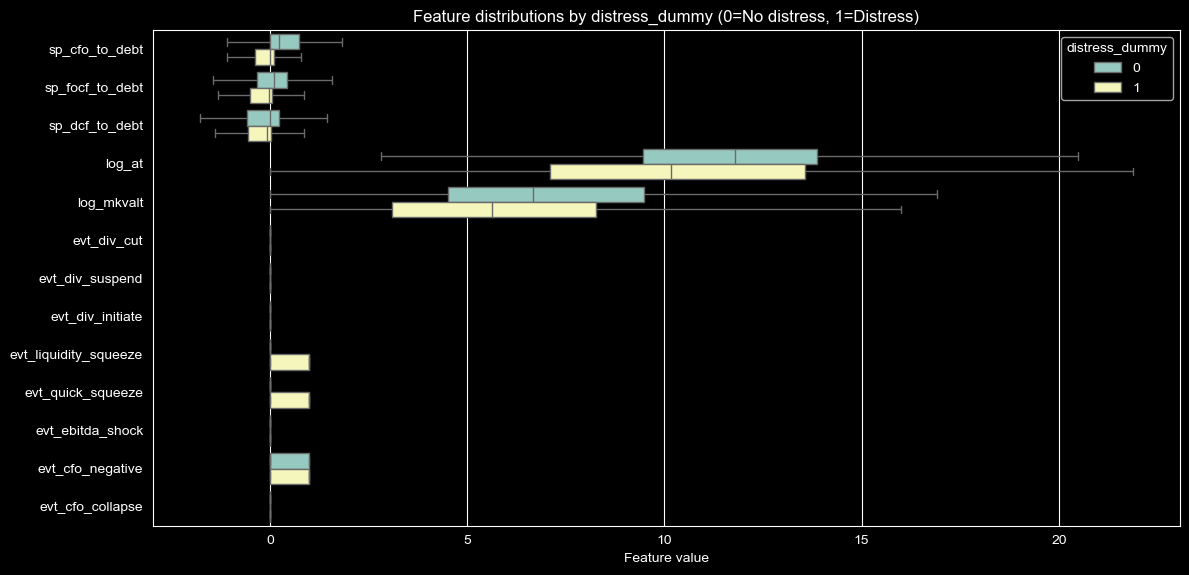

In [25]:
# =============================================================================
# Visual EDA: Feature distributions by distress flag
#   - Quick separation check: do distressed vs non-distressed firms differ in levels?
#   - Uses a horizontal boxplot for comparability across features
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Objective: visualize feature distribution differences for distressed vs non-distressed observations.

plot_df = train_pool.copy() if "train_pool" in globals() else df.copy()

flag_col = "distress_dummy" if "distress_dummy" in plot_df.columns else (
    "target_next_year_distress" if "target_next_year_distress" in plot_df.columns else None
)
if flag_col is None:
    raise KeyError("No distress flag found. Expected 'distress_dummy' or 'target_next_year_distress' in the data.")

plot_feats = [c for c in (feats if "feats" in globals() else []) if c in plot_df.columns]
if not plot_feats:
    plot_feats = [c for c in (z_cols if "z_cols" in globals() else []) if c in plot_df.columns]
if not plot_feats:
    raise KeyError(
        "No feature columns found to plot. Expected 'feats' or 'z_cols' to exist and be present in the data.")

tmp = plot_df[[flag_col] + plot_feats].copy()
tmp[flag_col] = pd.to_numeric(tmp[flag_col], errors="coerce").astype("Int64")
tmp = tmp[tmp[flag_col].isin([0, 1])].copy()

long = tmp.melt(id_vars=[flag_col], value_vars=plot_feats, var_name="feature", value_name="value")
long["value"] = pd.to_numeric(long["value"], errors="coerce")
long = long.dropna(subset=["value"])

fig, ax = plt.subplots(figsize=(12, max(4.5, 0.45 * len(plot_feats))))
sns.boxplot(
    data=long,
    x="value",
    y="feature",
    hue=flag_col,
    orient="h",
    showfliers=False,
    ax=ax,
)
ax.set_title(f"Feature distributions by {flag_col} (0=No distress, 1=Distress)")
ax.set_xlabel("Feature value")
ax.set_ylabel("")
ax.legend(title=flag_col, loc="best")
plt.tight_layout()
plt.show()

In [26]:
# =============================================================================
# Sanity checks on the distress proxy
#   - Component prevalence (each condition and joint condition)
#   - Distress rate by firm size decile (log assets) to check monotonic patterns
# =============================================================================

print(pd.Series({
    "hl_ffo": hl_ffo.mean(),
    "hl_cap": hl_cap.mean(),
    "hl_deb": hl_deb.mean(),
    "hl_all": is_highly_leveraged.mean()
}))
df["size_decile"] = pd.qcut(df["log_at"], 10, duplicates="drop")
print(df.groupby("size_decile")["distress_dummy"].mean())

hl_ffo    0.495567
hl_cap    0.316846
hl_deb    0.482848
hl_all    0.229065
dtype: float64
size_decile
(-0.001, 6.528]     0.523391
(6.528, 8.356]      0.351160
(8.356, 9.487]      0.266898
(9.487, 10.488]     0.206933
(10.488, 11.476]    0.195174
(11.476, 12.507]    0.196933
(12.507, 13.39]     0.178533
(13.39, 14.213]     0.208106
(14.213, 15.218]    0.227733
(15.218, 21.886]    0.225703
Name: distress_dummy, dtype: float64


/var/folders/p1/_cwwbdbj51q1lwpynfnzdxpm0000gn/T/ipykernel_879/2342790164.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("size_decile")["distress_dummy"].mean())


### 5.5 Endogeneity & Simultaneity Bias: A Critical Note
As highlighted by recent literature (e.g., Roberts 2015, Jiang 2017), modeling capital structure as a predictor of credit outcomes is prone to **endogeneity**. 

1. **Simultaneity**: Firms choose their leverage (Debt/Capital, etc.) based on their expected future credit risk and investment opportunities. Thus, leverage and distress outcomes are determined simultaneously in equilibrium.
2. **Reverse Causality**: While high leverage may lead to distress, the *anticipation* of distress may also force firms to seek more debt (if they follow pecking order) or prevent them from accessing debt (if credit constrained).

**Mitigation in this notebook:**
- While we use a standard Logistic Regression for transparency and baseline benchmarking, we acknowledge that the coefficients should be interpreted as **predictive associations** rather than pure causal effects.
- Future iterations should explore **Instrumental Variables (IV)** or **GMM** estimation (e.g., using industry-median leverage or historical tax changes as instruments) to better identify the causal impact of leverage on distress.


In [27]:
# =============================================================================
# Persistence Benchmark (Economic Sanity Check)
#   - Does the ML model add value over simply assuming distress persists?
#   - We use 'distress_dummy' (current year) to predict 'target_next_year_distress'
# =============================================================================
from sklearn.metrics import f1_score, accuracy_score

for name, d in [("VAL", val), ("TEST", test)]:
    y_true = d[TARGET_COL].astype(int)
    y_bench = d["distress_dummy"].astype(int)

    auc_bench = roc_auc_score(y_true, y_bench)
    f1_bench = f1_score(y_true, y_bench)
    acc_bench = accuracy_score(y_true, y_bench)

    print(f"--- Persistence Benchmark ({name}) ---")
    print(f"AUC: {auc_bench:.4f} | F1: {f1_bench:.4f} | Accuracy: {acc_bench:.4f}")


--- Persistence Benchmark (VAL) ---
AUC: 0.7862 | F1: 0.6860 | Accuracy: 0.8514
--- Persistence Benchmark (TEST) ---
AUC: 0.7901 | F1: 0.6949 | Accuracy: 0.8439


## 6. Modeling: Baseline out-of-sample supervised learning

This section trains a simple, interpretable classifier on the **TRAIN** split, selects a small hyperparameter setting using the **VAL** split, and reports final performance on the **TEST** split (held out, label_year > train cutoff).  

**Goal:** Predict `target_next_year_distress` one year ahead from standardized financial-ratio features.


In [28]:
# =============================================================================
# 6.1 Setup: Features, target, and train/val/test matrices
# =============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# Prefer standardized feature columns created earlier (fit on TRAIN only)
if "z_cols" in globals():
    MODEL_FEATS = list(z_cols)
else:
    MODEL_FEATS = [f"z_{c}" for c in feats]  # fallback

# Basic sanity checks
for df_name, df_ in [("train", train), ("val", val), ("test", test)]:
    missing_feats = [c for c in MODEL_FEATS if c not in df_.columns]
    if missing_feats:
        raise KeyError(f"{df_name}: missing feature columns: {missing_feats}")

X_train = train[MODEL_FEATS].to_numpy(dtype=float)
y_train = train[TARGET_COL].astype(int).to_numpy()

X_val = val[MODEL_FEATS].to_numpy(dtype=float)
y_val = val[TARGET_COL].astype(int).to_numpy()

X_test = test[MODEL_FEATS].to_numpy(dtype=float)
y_test = test[TARGET_COL].astype(int).to_numpy()

# Defensive: ensure model inputs are finite
def _assert_finite(name, X):
    bad = ~np.isfinite(X)
    if bad.any():
        rows, cols = np.where(bad)
        raise ValueError(f"{name}: found non-finite values at {len(rows)} cells (e.g., row={rows[0]}, col={MODEL_FEATS[cols[0]]}).")

_assert_finite("X_train", X_train)
_assert_finite("X_val", X_val)
_assert_finite("X_test", X_test)

print("Modeling matrix shapes:")
print(f"  X_train: {X_train.shape} | y_train mean={y_train.mean():.4f}")
print(f"  X_val:   {X_val.shape} | y_val mean={y_val.mean():.4f}")
print(f"  X_test:  {X_test.shape} | y_test mean={y_test.mean():.4f}")

Modeling matrix shapes:
  X_train: (44783, 13) | y_train mean=0.2527
  X_val:   (6415, 13) | y_val mean=0.2469
  X_test:  (12404, 13) | y_test mean=0.2627


In [29]:
# =============================================================================
# 6.2 Baseline model: Logistic Regression (tuned on VAL)
#   - Interpretable, strong baseline for tabular finance ratios
#   - We tune C on VAL; you can expand the grid later if needed
# =============================================================================
C_GRID = [0.01, 0.1, 1.0, 10.0]

best = {"C": None, "val_auc": -np.inf, "model": None}

for C in C_GRID:
    clf = LogisticRegression(
        C=C,
        solver="lbfgs",
        max_iter=500,
        class_weight="balanced",  # practical default with ~10% positives
        n_jobs=None,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)

    if val_auc > best["val_auc"]:
        best.update({"C": C, "val_auc": val_auc, "model": clf})

print(f"Best LogisticRegression on VAL: C={best['C']} | AUC={best['val_auc']:.4f}")
logit = best["model"]


Best LogisticRegression on VAL: C=0.1 | AUC=0.6658


In [30]:
# =============================================================================
# 6.2b Statistical Inference & Economic Interpretation (Statsmodels)
#   - sklearn is great for prediction but lacks p-values and inference.
#   - We re-estimate the logit using statsmodels to audit statistical significance.
#   - We also report Marginal Effects to see economic significance.
# =============================================================================
import statsmodels.api as sm

# Add constant for intercept
X_train_sm = sm.add_constant(X_train)
# Panel dependence: use cluster-robust SEs (firm-level) for inference in the training panel
try:
    _groups = train["firm_id"].to_numpy()
    sm_model = sm.Logit(y_train, X_train_sm).fit(
        disp=0,
        cov_type="cluster",
        cov_kwds={"groups": _groups},
    )
    _se_note = "cluster-robust SEs (firm-level)"
except Exception as e:
    # Fallback: still produce estimates, but avoid overstating inference quality
    sm_model = sm.Logit(y_train, X_train_sm).fit(disp=0)
    _se_note = f"non-robust SEs (fallback; clustering failed: {e})"

print(f"\n=== Statsmodels Logistic Regression Summary ({_se_note}) ===")
print(sm_model.summary(xname=["const"] + MODEL_FEATS))

# Marginal Effects at the Mean (MEM)
try:
    mfx = sm_model.get_margeff(at="mean")
    print("\n=== Economic Significance: Marginal Effects at the Mean ===")
    print(mfx.summary())
except Exception as e:
    print(f"\nCould not calculate marginal effects: {e}")

# AIC / BIC / Pseudo-R2
print(f"\nModel Fit:")
print(f"  Pseudo R2 (McFadden): {sm_model.prsquared:.4f}")
print(f"  AIC: {sm_model.aic:.2f}")
print(f"  BIC: {sm_model.bic:.2f}")



=== Statsmodels Logistic Regression Summary (cluster-robust SEs (firm-level)) ===
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                44783
Model:                          Logit   Df Residuals:                    44769
Method:                           MLE   Df Model:                           13
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                 0.08690
Time:                        23:13:51   Log-Likelihood:                -23114.
converged:                       True   LL-Null:                       -25313.
Covariance Type:              cluster   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.7285      0.031    -55.383      0.000      -1.790      -1.667
z_sp_cfo_to_deb

In [31]:
# =============================================================================
# 6.2c Temporal Stability (Walk-Forward Validation)
#   - We assess whether model performance is stable across different time regimes.
#   - Using the expanding-window folds defined in diagnostics.
# =============================================================================
temporal_results = []

FOLD_FEATS = [c for c in feats if c in train_pool.columns]
if not FOLD_FEATS:
    raise KeyError("No usable feature columns found in train_pool for temporal CV. Expected 'feats' columns to exist.")

for i, (tr_idx, va_idx, tr_years, va_year) in enumerate(folds, 1):
    tr_df = train_pool.loc[tr_idx, FOLD_FEATS + [TARGET_COL]].copy()
    va_df = train_pool.loc[va_idx, FOLD_FEATS + [TARGET_COL]].copy()

    # Targets
    y_tr = pd.to_numeric(tr_df[TARGET_COL], errors="coerce").astype(int).to_numpy()
    y_va = pd.to_numeric(va_df[TARGET_COL], errors="coerce").astype(int).to_numpy()

    # Features: fold-local preprocessing (no leakage)
    X_tr_df = tr_df[FOLD_FEATS].replace([np.inf, -np.inf], np.nan).apply(pd.to_numeric, errors="coerce")
    X_va_df = va_df[FOLD_FEATS].replace([np.inf, -np.inf], np.nan).apply(pd.to_numeric, errors="coerce")

    # Median imputation fit on fold-train only
    fold_fill = X_tr_df.median(numeric_only=True)
    X_tr_df = X_tr_df.fillna(fold_fill)
    X_va_df = X_va_df.fillna(fold_fill)

    # Winsorize using fold-train only
    fold_bounds = {}
    for c in FOLD_FEATS:
        s = pd.to_numeric(X_tr_df[c], errors="coerce")
        fold_bounds[c] = (s.quantile(WINSOR_LOWER_Q), s.quantile(WINSOR_UPPER_Q))

    for c, (lo, hi) in fold_bounds.items():
        X_tr_df[c] = pd.to_numeric(X_tr_df[c], errors="coerce").clip(lo, hi)
        X_va_df[c] = pd.to_numeric(X_va_df[c], errors="coerce").clip(lo, hi)

    # Standardize fit on fold-train only
    fold_scaler = StandardScaler().fit(X_tr_df.to_numpy(dtype=float))
    X_tr = fold_scaler.transform(X_tr_df.to_numpy(dtype=float))
    X_va = fold_scaler.transform(X_va_df.to_numpy(dtype=float))

    # Fit model (using best C from tuning)
    fold_clf = LogisticRegression(C=best["C"], solver="lbfgs", max_iter=500, class_weight="balanced", random_state=42)
    fold_clf.fit(X_tr, y_tr)

    # Evaluate
    probs = fold_clf.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, probs)
    ap = average_precision_score(y_va, probs)

    temporal_results.append({
        "Fold": i,
        "Val_Year": va_year,
        "Train_End": tr_years[-1],
        "AUC": auc,
        "PR-AUC": ap
    })

temporal_df = pd.DataFrame(temporal_results)
print("\n=== Temporal Stability: Walk-Forward Results ===")
print(temporal_df.round(4))
print(f"\nAverage AUC across folds: {temporal_df['AUC'].mean():.4f}")



=== Temporal Stability: Walk-Forward Results ===
   Fold  Val_Year  Train_End     AUC  PR-AUC
0     1      2018       2017  0.6934  0.4834
1     2      2019       2018  0.6775  0.5037
2     3      2020       2019  0.6671  0.4712
3     4      2021       2020  0.6771  0.4385

Average AUC across folds: 0.6788


In [32]:
# =============================================================================
# 6.3 Evaluation: VAL and TEST (AUC, PR-AUC, Brier) + thresholding
# =============================================================================
def evaluate_split(name, y_true, y_proba, threshold=0.5):
    auc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)

    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"AUC (ROC): {auc:.4f}")
    print(f"Average Precision (PR-AUC): {ap:.4f}")
    print(f"Brier score (calibration): {brier:.4f}")
    print(f"Threshold: {threshold:.3f}")
    print("Confusion matrix [ [TN FP] [FN TP] ]:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Explicitly pull out Sensitivity and Specificity
    # TN FP
    # FN TP
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Sensitivity (Recall of Distress): {sensitivity:.4f}")
    print(f"Specificity (Recall of Non-Distress): {specificity:.4f}")
    
    return {"auc": auc, "ap": ap, "brier": brier, "cm": cm, "sens": sensitivity, "spec": specificity}

val_proba = logit.predict_proba(X_val)[:, 1]
test_proba = logit.predict_proba(X_test)[:, 1]

# Choose an operational threshold using VAL (maximize F1 as a simple practical rule)
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1[1:])  # skip first point (threshold undefined)
best_thr = thr[best_idx]

_ = evaluate_split("VAL (threshold from VAL-F1)", y_val, val_proba, threshold=float(best_thr))
_ = evaluate_split("TEST (same threshold)", y_test, test_proba, threshold=float(best_thr))



=== VAL (threshold from VAL-F1) ===
AUC (ROC): 0.6658
Average Precision (PR-AUC): 0.4642
Brier score (calibration): 0.2191
Threshold: 0.424
Confusion matrix [ [TN FP] [FN TP] ]:
[[2408 2423]
 [ 449 1135]]

Classification report:
              precision    recall  f1-score   support

           0     0.8428    0.4984    0.6264      4831
           1     0.3190    0.7165    0.4415      1584

    accuracy                         0.5523      6415
   macro avg     0.5809    0.6075    0.5339      6415
weighted avg     0.7135    0.5523    0.5808      6415

Sensitivity (Recall of Distress): 0.7165
Specificity (Recall of Non-Distress): 0.4984

=== TEST (same threshold) ===
AUC (ROC): 0.6768
Average Precision (PR-AUC): 0.4734
Brier score (calibration): 0.2205
Threshold: 0.424
Confusion matrix [ [TN FP] [FN TP] ]:
[[4647 4499]
 [ 885 2373]]

Classification report:
              precision    recall  f1-score   support

           0     0.8400    0.5081    0.6332      9146
           1     0.3453 

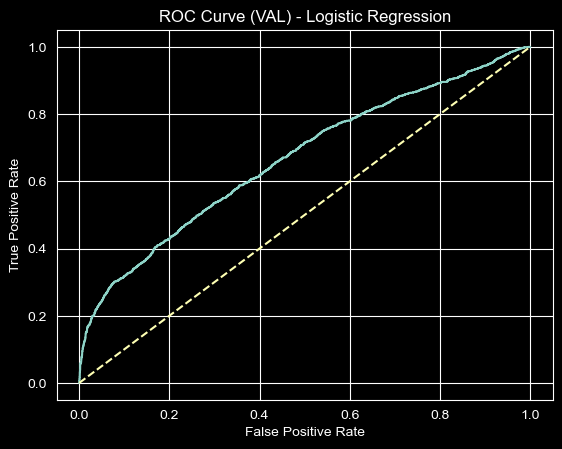

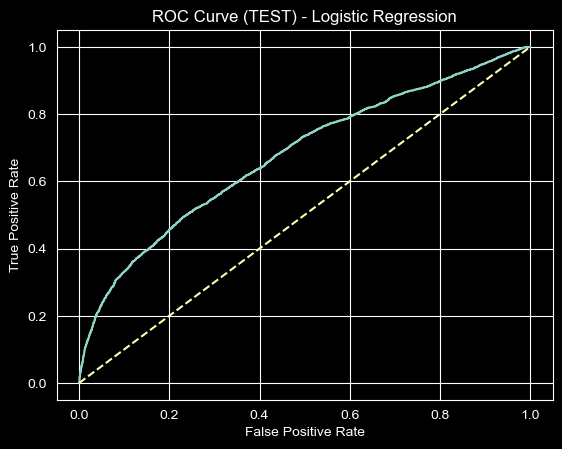

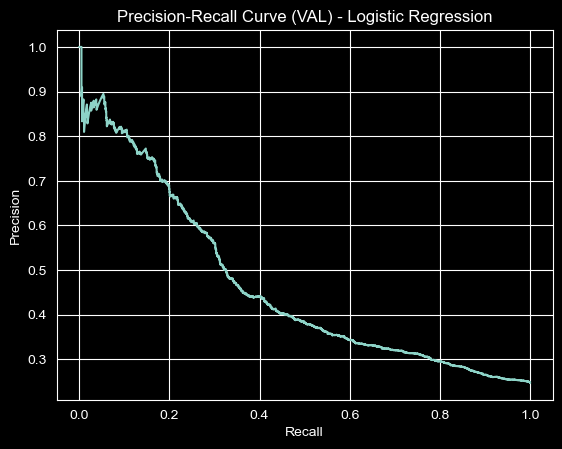

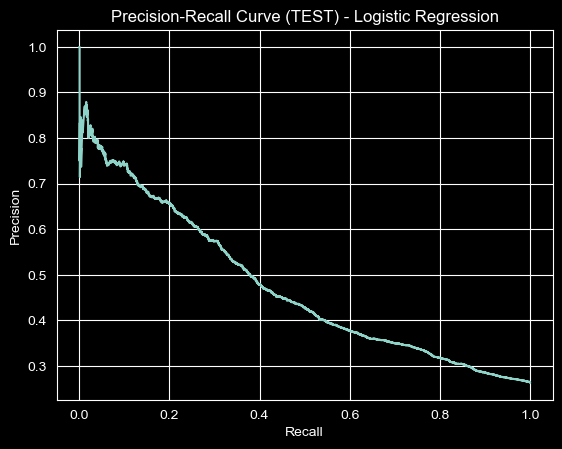

In [33]:
# =============================================================================
# 6.4 Diagnostic plots: ROC and Precision-Recall (VAL vs TEST)
# =============================================================================
def plot_roc(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

def plot_pr(y_true, y_proba, title):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(r, p)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

plot_roc(y_val, val_proba, "ROC Curve (VAL) - Logistic Regression")
plot_roc(y_test, test_proba, "ROC Curve (TEST) - Logistic Regression")

plot_pr(y_val, val_proba, "Precision-Recall Curve (VAL) - Logistic Regression")
plot_pr(y_test, test_proba, "Precision-Recall Curve (TEST) - Logistic Regression")


In [34]:
# =============================================================================
# 6.5 Interpretability: coefficients as (approx.) log-odds contributions
# =============================================================================
coef = pd.Series(logit.coef_.ravel(), index=MODEL_FEATS).sort_values(ascending=False)

summary = pd.DataFrame({
    "feature": coef.index,
    "coef_log_odds": coef.values,
    "odds_ratio": np.exp(coef.values),  # change from 0->1 for binary, per 1SD for scaled continuous
}).sort_values("coef_log_odds", ascending=False)

print("Top positive (higher distress risk):")
display(summary.head(10))

print("Top negative (lower distress risk):")
display(summary.tail(10).iloc[::-1])


Top positive (higher distress risk):


,feature,coef_log_odds,odds_ratio
0,evt_liquidity_squeeze,0.762396,2.143406
1,evt_quick_squeeze,0.431403,1.539416
2,evt_ebitda_shock,0.421380,1.524063
3,evt_cfo_negative,0.416321,1.516373
4,evt_cfo_collapse,0.195279,1.215651
5,z_sp_dcf_to_debt,0.158517,1.171772
6,evt_div_suspend,0.091704,1.096041
7,evt_div_initiate,0.080585,1.083921
8,z_sp_focf_to_debt,0.045441,1.046489
9,evt_div_cut,0.036593,1.037270


Top negative (lower distress risk):


,feature,coef_log_odds,odds_ratio
12,z_sp_cfo_to_debt,-0.277342,0.757795
11,z_log_at,-0.151876,0.859095
10,z_log_mkvalt,-0.053913,0.947515
9,evt_div_cut,0.036593,1.037270
8,z_sp_focf_to_debt,0.045441,1.046489
7,evt_div_initiate,0.080585,1.083921
6,evt_div_suspend,0.091704,1.096041
5,z_sp_dcf_to_debt,0.158517,1.171772
4,evt_cfo_collapse,0.195279,1.215651
3,evt_cfo_negative,0.416321,1.516373


### 6.6 Optional benchmark: Tree-based model (non-linear)

If you want a second point of reference without heavy tuning, a small gradient-boosted tree model often performs well on tabular data. This is optional for the seminar paper; keep Logistic Regression as the interpretability baseline.


In [35]:
### 6.6 Optional benchmark: Cost-sensitive boosted trees (non-linear) + calibrated PDs

import numpy as np
import pandas as pd
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.tree import DecisionTreeRegressor, export_text


# =============================================================================
# 0) HELPER UTILITIES
# =============================================================================
def _safe_feature_names(n_features: int):
    cand = globals().get("FEATURE_COLS", globals().get("MODEL_FEATS", None))
    if isinstance(cand, (list, tuple)) and len(cand) == n_features:
        return list(cand)
    return [f"f{i}" for i in range(n_features)]


def gmean_tpr_tnr(y_true, proba, thr):
    y_hat = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0, 1]).ravel()
    tpr = tp / max(tp + fn, 1)
    tnr = tn / max(tn + fp, 1)
    gmean = float(np.sqrt(tpr * tnr))
    return gmean, tpr, tnr, np.array([[tn, fp], [fn, tp]])


def expected_cost(y_true, proba, thr, cost_fn: float, cost_fp: float):
    y_hat = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0, 1]).ravel()
    return float(cost_fn * fn + cost_fp * fp), np.array([[tn, fp], [fn, tp]])


def pd_decile_table(y_true, proba, n_bins=10):
    df = pd.DataFrame({"y": np.asarray(y_true).astype(int), "p": np.asarray(proba).astype(float)})
    # qcut can fail with many ties; use rank to stabilize
    r = df["p"].rank(method="first")
    df["bin"] = pd.qcut(r, q=n_bins, labels=False) + 1  # 1..n_bins (1=lowest risk)
    out = (
        df.groupby("bin", as_index=False)
        .agg(n=("y", "size"), realized_rate=("y", "mean"), avg_pd=("p", "mean"),
             min_pd=("p", "min"), max_pd=("p", "max"))
        .sort_values("bin")
    )
    out["lift_vs_base"] = out["realized_rate"] / max(df["y"].mean(), 1e-12)
    return out


# =============================================================================
# 1) SPLIT VALIDATION INTO:
#    - early-stopping set (VAL_ES)
#    - calibration + threshold selection set (VAL_CAL)
#    This prevents using the same data for early stopping AND calibration/thresholding.
# =============================================================================
CAL_SIZE = 0.50  # half of VAL held for calibration + threshold selection

try:
    X_val_es, X_val_cal, y_val_es, y_val_cal = train_test_split(
        X_val, y_val,
        test_size=CAL_SIZE,
        random_state=42,
        stratify=y_val
    )
except Exception:
    # fallback if stratify fails (e.g., too few positives)
    X_val_es, X_val_cal, y_val_es, y_val_cal = train_test_split(
        X_val, y_val,
        test_size=CAL_SIZE,
        random_state=42
    )

# =============================================================================
# 2) COST-SENSITIVE WEIGHTS (weighted cross-entropy spirit: α_FN > α_FP)
#    We implement via sample_weight to avoid double-counting with scale_pos_weight.
# =============================================================================
pos = int(np.sum(y_train))
neg = int(len(y_train) - pos)
imbalance_ratio = neg / max(pos, 1)

# Choose explicit costs (finance logic: FN typically more costly than FP).
# Default: match imbalance ratio -> roughly "balanced" effective loss.
COST_FP = 1.0
COST_FN = float(imbalance_ratio)

w_train = np.where(np.asarray(y_train).astype(int) == 1, COST_FN, COST_FP)
w_val_es = np.where(np.asarray(y_val_es).astype(int) == 1, COST_FN, COST_FP)

# =============================================================================
# 3) XGBOOST SPECIFICATION (strong tabular baseline; modest regularization)
#    Key change: early stopping explicitly on PR-AUC (aucpr), not logloss.
# =============================================================================
base_params = dict(
    objective="binary:logistic",
    booster="gbtree",
    tree_method="hist",
    n_estimators=5000,
    learning_rate=0.02,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=5.0,
    reg_alpha=0.0,
    gamma=0.0,
    max_delta_step=1,
    random_state=42,
    n_jobs=-1,
    # IMPORTANT: do NOT set scale_pos_weight if using sample_weight for costs
    scale_pos_weight=1.0,
)

# Early stop on PR-AUC explicitly (your learning curve peaked in aucpr before logloss)
try:
    es = xgb.callback.EarlyStopping(
        rounds=200,
        metric_name="aucpr",
        data_name="validation_0",
        maximize=True,
        save_best=True
    )
    xgb_clf = XGBClassifier(**base_params, eval_metric=["aucpr", "auc", "logloss"], callbacks=[es])
    xgb_clf.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val_es, y_val_es)],
        sample_weight_eval_set=[w_val_es],
        verbose=200
    )
except TypeError:
    # fallback for older API variants
    xgb_clf = XGBClassifier(**base_params, eval_metric=["aucpr", "auc", "logloss"], early_stopping_rounds=200)
    xgb_clf.fit(
        X_train, y_train,
        sample_weight=w_train,
        eval_set=[(X_val_es, y_val_es)],
        sample_weight_eval_set=[w_val_es],
        verbose=200
    )

# =============================================================================
# 4) CALIBRATION (manual isotonic; avoids sklearn cv='prefit' deprecation path)
#    Calibrate ONLY on VAL_CAL (not used for early stopping).
# =============================================================================
raw_cal = xgb_clf.predict_proba(X_val_cal)[:, 1]
raw_test = xgb_clf.predict_proba(X_test)[:, 1]

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(raw_cal, np.asarray(y_val_cal).astype(int))

val_cal_proba = iso.predict(raw_cal)
test_proba = iso.predict(raw_test)

print("XGBoost (cost-sensitive + early stop on VAL_ES aucpr + isotonic calib on VAL_CAL):")
print(
    f"  VAL_CAL AUC={roc_auc_score(y_val_cal, val_cal_proba):.4f} | "
    f"PR-AUC={average_precision_score(y_val_cal, val_cal_proba):.4f} | "
    f"Brier={brier_score_loss(y_val_cal, val_cal_proba):.4f}"
)
print(
    f"  TEST    AUC={roc_auc_score(y_test, test_proba):.4f} | "
    f"PR-AUC={average_precision_score(y_test, test_proba):.4f} | "
    f"Brier={brier_score_loss(y_test, test_proba):.4f}"
)

# =============================================================================
# 5) THRESHOLDS: (i) cost-based, (ii) G-mean, (iii) capacity (top X%)
#    Thresholds chosen on VAL_CAL; then reported on TEST.
# =============================================================================
grid = np.linspace(0.01, 0.99, 99)

# (i) Cost-based threshold: minimize expected misclassification cost
best_cost = {"thr": 0.5, "cost": np.inf, "cm": None}
for t in grid:
    c, cm = expected_cost(y_val_cal, val_cal_proba, t, cost_fn=COST_FN, cost_fp=COST_FP)
    if c < best_cost["cost"]:
        best_cost.update({"thr": float(t), "cost": float(c), "cm": cm})

# (ii) G-mean threshold (imbalance-robust diagnostic)
best_g = {"thr": 0.5, "gmean": -1, "tpr": None, "tnr": None, "cm": None}
for t in grid:
    g, tpr, tnr, cm = gmean_tpr_tnr(y_val_cal, val_cal_proba, t)
    if g > best_g["gmean"]:
        best_g.update({"thr": float(t), "gmean": g, "tpr": tpr, "tnr": tnr, "cm": cm})

# (iii) Capacity rule: flag top X% by PD (common in finance screening / surveillance)
TOP_PCT = 0.10
thr_top = float(np.quantile(val_cal_proba, 1 - TOP_PCT))


def report_threshold(name, thr):
    g_val, tpr_val, tnr_val, cm_val = gmean_tpr_tnr(y_val_cal, val_cal_proba, thr)
    g_t, tpr_t, tnr_t, cm_t = gmean_tpr_tnr(y_test, test_proba, thr)

    # precision / flag rate
    tn, fp, fn, tp = cm_t.ravel()
    prec = tp / max(tp + fp, 1)
    flag = (tp + fp) / max((tp + fp + tn + fn), 1)

    print(f"\n{name}: threshold t={thr:.3f}")
    print(f"  VAL_CAL  G-mean={g_val:.3f} | TPR={tpr_val:.3f} | TNR={tnr_val:.3f} | CM:\n{cm_val}")
    print(
        f"  TEST     G-mean={g_t:.3f} | TPR={tpr_t:.3f} | TNR={tnr_t:.3f} | Precision={prec:.3f} | FlagRate={flag:.3f} | CM:\n{cm_t}")


report_threshold("Cost-based (min expected cost; COST_FN vs COST_FP)", best_cost["thr"])
report_threshold("G-mean (diagnostic)", best_g["thr"])
report_threshold(f"Top-{int(TOP_PCT * 100)}% capacity rule", thr_top)

# =============================================================================
# 6) FINANCE-STYLE PD SORTS (deciles): monotonicity check + lift
# =============================================================================
print("\nPD Deciles on VAL_CAL (1=lowest risk, 10=highest risk):")
print(pd_decile_table(y_val_cal, val_cal_proba, n_bins=10).to_string(index=False))

print("\nPD Deciles on TEST (1=lowest risk, 10=highest risk):")
print(pd_decile_table(y_test, test_proba, n_bins=10).to_string(index=False))

# =============================================================================
# 7) INTERPRETABILITY: “single-tree approximation” of the calibrated PD surface
#    (practical analogue to merging rules into an interpretable tree)
# =============================================================================
feature_names = _safe_feature_names(X_train.shape[1])

sur = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=max(50, int(0.01 * len(y_train))),
    random_state=42
)

# Fit surrogate on TRAIN predictions (do not use TEST); calibrated PD mapping included
raw_train = xgb_clf.predict_proba(X_train)[:, 1]
train_pd = iso.predict(raw_train)
sur.fit(X_train, train_pd)

print("\nSurrogate tree (depth<=4) approximating calibrated PDs:")
print(export_text(sur, feature_names=feature_names))

# =============================================================================
# 8) FEATURE IMPORTANCE: prefer SHAP; fallback to gain if SHAP unavailable
# =============================================================================
try:
    import shap  # optional

    explainer = shap.TreeExplainer(xgb_clf)
    idx = np.random.RandomState(42).choice(len(X_train), size=min(2000, len(X_train)), replace=False)
    shap_values = explainer.shap_values(X_train[idx])

    imp = np.mean(np.abs(shap_values), axis=0)
    top = np.argsort(-imp)[:20]
    print("\nTop-20 features by mean(|SHAP|):")
    for j in top:
        print(f"{feature_names[j]}: {imp[j]:.6f}")
except Exception:
    booster = xgb_clf.get_booster()
    score = booster.get_score(importance_type="gain")  # {"f0": gain, ...}
    imp = np.zeros(X_train.shape[1], dtype=float)
    for k, v in score.items():
        if isinstance(k, str) and k.startswith("f") and k[1:].isdigit():
            j = int(k[1:])
            if 0 <= j < imp.size:
                imp[j] = float(v)

    top = np.argsort(-imp)[:20]
    print("\nTop-20 features by XGBoost gain (fallback; SHAP unavailable):")
    for j in top:
        print(f"{feature_names[j]}: {imp[j]:.6f}")


[0]	validation_0-aucpr:0.73806	validation_0-auc:0.75764	validation_0-logloss:0.68954
[200]	validation_0-aucpr:0.79427	validation_0-auc:0.79761	validation_0-logloss:0.54720
[400]	validation_0-aucpr:0.79845	validation_0-auc:0.80230	validation_0-logloss:0.54049
[600]	validation_0-aucpr:0.79982	validation_0-auc:0.80418	validation_0-logloss:0.53821
[800]	validation_0-aucpr:0.80009	validation_0-auc:0.80477	validation_0-logloss:0.53731
[1000]	validation_0-aucpr:0.80115	validation_0-auc:0.80532	validation_0-logloss:0.53654
[1200]	validation_0-aucpr:0.80073	validation_0-auc:0.80604	validation_0-logloss:0.53570
[1205]	validation_0-aucpr:0.80081	validation_0-auc:0.80613	validation_0-logloss:0.53565
XGBoost (cost-sensitive + early stop on VAL_ES aucpr + isotonic calib on VAL_CAL):
  VAL_CAL AUC=0.7944 | PR-AUC=0.5747 | Brier=0.1422
  TEST    AUC=0.7948 | PR-AUC=0.5714 | Brier=0.1500

Cost-based (min expected cost; COST_FN vs COST_FP): threshold t=0.250
  VAL_CAL  G-mean=0.728 | TPR=0.686 | TNR=0.7

/Users/test/anaconda3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Top-20 features by mean(|SHAP|):
z_sp_cfo_to_debt: 0.826070
evt_liquidity_squeeze: 0.307012
z_log_at: 0.271325
z_sp_dcf_to_debt: 0.258965
z_sp_focf_to_debt: 0.182215
z_log_mkvalt: 0.125545
evt_quick_squeeze: 0.097145
evt_cfo_negative: 0.071880
evt_ebitda_shock: 0.016891
evt_cfo_collapse: 0.014186
evt_div_initiate: 0.005560
evt_div_cut: 0.004274
evt_div_suspend: 0.001107


In [36]:
# =============================================================================
# 6.7 Export: out-of-sample predictions (VAL and TEST) for reporting / appendix
# =============================================================================
ID_COLS = [c for c in ["gvkey", "fyear", "label_year"] if c in train.columns]

pred_val = val[ID_COLS + [TARGET_COL]].copy()
pred_val["p_distress_logit"] = val_proba

pred_test = test[ID_COLS + [TARGET_COL]].copy()
pred_test["p_distress_logit"] = test_proba

pred_oos = pd.concat(
    [pred_val.assign(split="VAL"), pred_test.assign(split="TEST")],
    ignore_index=True
)

out_csv = "oos_predictions_logit.csv"
pred_oos.to_csv(out_csv, index=False)
print(f"Saved: {out_csv} | rows={len(pred_oos):,} | cols={pred_oos.shape[1]}")


Saved: oos_predictions_logit.csv | rows=18,819 | cols=6


## 7. Decision Support: Event Lift, Explanation, Scenario Analysis, Anticipation & Simulation

This section extends the predictive distress model with decision-grade diagnostics and scenario tooling.

Important interpretation note (Pearl / *Book of Why*):
- Event flags and SHAP explain *predictive associations* (what typically co-occurs with higher distress risk).
- The scenario engine below is a *model-implied counterfactual under explicit accounting assumptions*; it is **not** a proven causal effect without an identification strategy.


Baseline distress rate (overall): 25.4033%  |  N=63,602


,event,n_events,event_rate,distress_rate_given_event,lift_vs_base,pp_diff_vs_base
0,evt_lev_spike,1235,0.019418,0.750607,2.954764,0.496574
1,evt_liquidity_squeeze,17043,0.267963,0.438186,1.724917,0.184153
2,evt_quick_squeeze,18250,0.286941,0.416164,1.638230,0.162131
3,evt_cfo_negative,23672,0.372190,0.352949,1.389382,0.098916
4,evt_cov_breach,30711,0.482862,0.347335,1.367283,0.093302
5,evt_cfo_collapse,2810,0.044181,0.280427,1.103901,0.026394
6,evt_div_suspend,1224,0.019245,0.269608,1.061311,0.015575
7,evt_ebitda_shock,2712,0.042640,0.257375,1.013155,0.003342
8,evt_div_cut,2007,0.031556,0.247135,0.972847,-0.006898
9,evt_cov_collapse,2729,0.042907,0.246977,0.972224,-0.007056


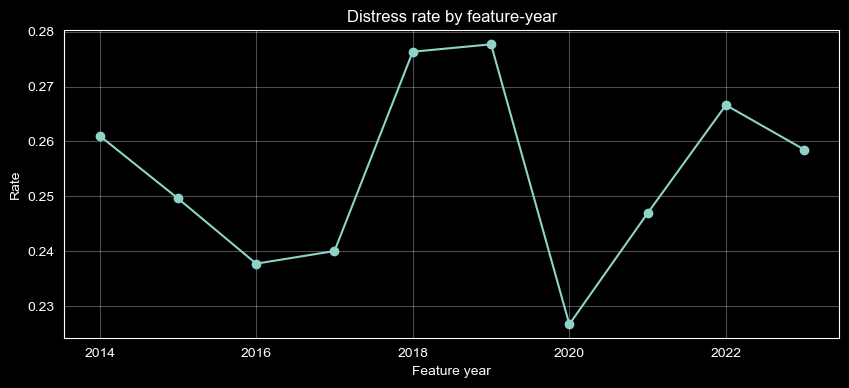

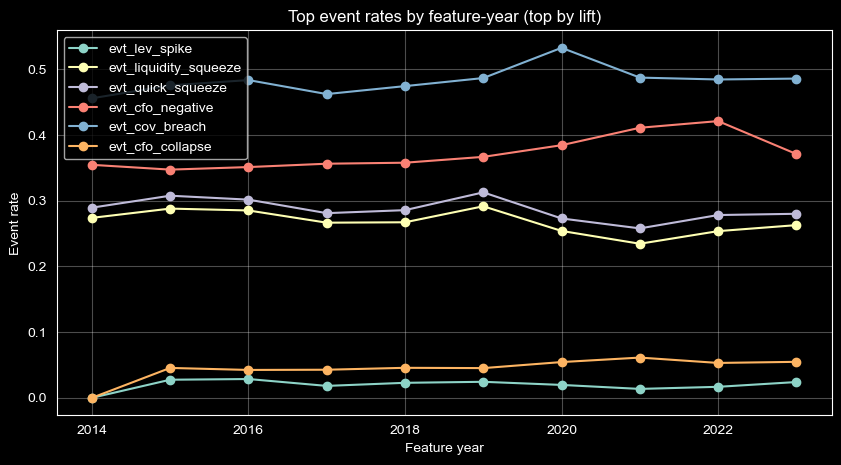

In [37]:
# =============================================================================
# 7.1 Baseline distress rate, event lift, and year clustering (distribution-aware)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Robust references ---
_df = df_split.copy() if "df_split" in globals() else (df_events.copy() if "df_events" in globals() else df.copy())
_target = TARGET_COL if "TARGET_COL" in globals() else (
    "target_next_year_distress" if "target_next_year_distress" in _df.columns else "distress_dummy"
)
if _target not in _df.columns:
    raise KeyError(f"Target not found. Expected TARGET_COL or 'target_next_year_distress'/'distress_dummy'. Got: {_target}")

_evt_cols = [c for c in _df.columns if c.startswith("evt_")]
if not _evt_cols:
    raise ValueError("No event columns found (expected columns starting with 'evt_').")

# Year for reporting (feature-year)
if "fyear" in _df.columns:
    _year = _df["fyear"]
else:
    # label_year = fyear + 1 (in this project); use feature-year = label_year - 1
    _year = _df["label_year"] - 1 if "label_year" in _df.columns else pd.Series(np.nan, index=_df.index)

base_rate = float(pd.to_numeric(_df[_target], errors="coerce").mean())
print(f"Baseline distress rate (overall): {base_rate:.4%}  |  N={len(_df):,}")

def event_lift_table(df_in: pd.DataFrame, target: str, event_cols: list[str]) -> pd.DataFrame:
    y = pd.to_numeric(df_in[target], errors="coerce")
    base = float(y.mean())
    rows = []
    for e in event_cols:
        s = pd.to_numeric(df_in[e], errors="coerce").fillna(0).astype(int)
        n = int(s.sum())
        prev = float(s.mean())
        cond = float(y[s == 1].mean()) if n > 0 else np.nan
        lift = (cond / base) if (pd.notna(cond) and base > 0) else np.nan
        pp = (cond - base) if pd.notna(cond) else np.nan
        rows.append((e, n, prev, cond, lift, pp))
    out = pd.DataFrame(
        rows,
        columns=["event", "n_events", "event_rate", "distress_rate_given_event", "lift_vs_base", "pp_diff_vs_base"],
    )
    return out.sort_values(["lift_vs_base", "n_events"], ascending=[False, False]).reset_index(drop=True)

lift_all = event_lift_table(_df, _target, _evt_cols)
display(lift_all.head(20))

# --- Year clustering ---
year_tbl = (
    _df.assign(feature_year=_year)
    .groupby("feature_year", dropna=True)[[_target] + _evt_cols]
    .mean(numeric_only=True)
    .sort_index()
)

# Plot: distress rate + a few key event rates (auto-select top by lift)
top_events = list(lift_all["event"].head(6).values)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(year_tbl.index, year_tbl[_target], marker="o")
ax.set_title("Distress rate by feature-year")
ax.set_xlabel("Feature year")
ax.set_ylabel("Rate")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
for e in top_events:
    if e in year_tbl.columns:
        ax.plot(year_tbl.index, year_tbl[e], marker="o", label=e)
ax.set_title("Top event rates by feature-year (top by lift)")
ax.set_xlabel("Feature year")
ax.set_ylabel("Event rate")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
plt.show()


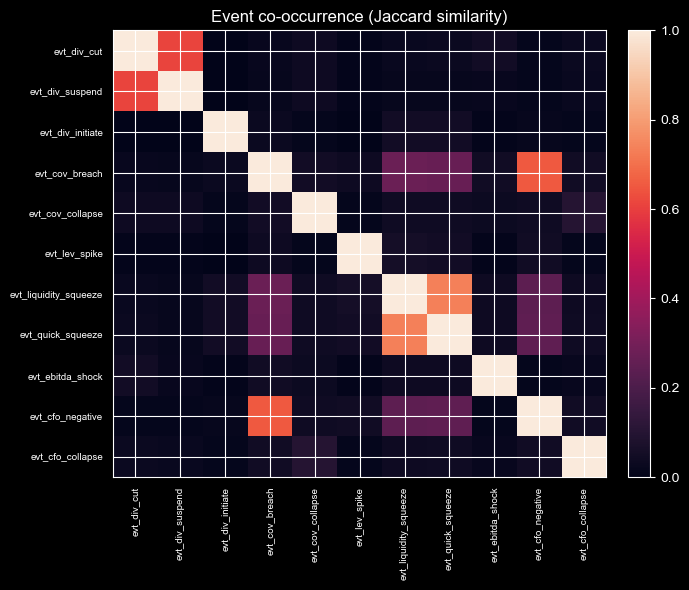

,event,n_cur0,p_activate_01,n_cur1,p_persist_11
0,evt_quick_squeeze,38234,0.165638,14998,0.583945
1,evt_cov_breach,28194,0.156062,25038,0.825705
2,evt_liquidity_squeeze,39284,0.153167,13948,0.569472
3,evt_cfo_negative,34024,0.094727,19208,0.821949
4,evt_cfo_collapse,50929,0.050227,2303,0.109422
5,evt_ebitda_shock,50965,0.046483,2267,0.151301
6,evt_cov_collapse,50988,0.045462,2244,0.183155
7,evt_div_cut,51543,0.037968,1689,0.029603
8,evt_div_initiate,49199,0.027175,4033,0.000000
9,evt_div_suspend,52197,0.023450,1035,0.000000


In [38]:
# =============================================================================
# 7.2 Event co-occurrence and transitions (anticipation)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_df = df_split.copy() if "df_split" in globals() else df_events.copy()
_target = TARGET_COL if "TARGET_COL" in globals() else "target_next_year_distress"
_evt_cols = [c for c in _df.columns if c.startswith("evt_")]

# Feature-year for ordering
if "fyear" in _df.columns:
    _df["_feature_year"] = _df["fyear"]
elif "label_year" in _df.columns:
    _df["_feature_year"] = _df["label_year"] - 1
else:
    raise KeyError("Need 'fyear' or 'label_year' to compute event transitions.")

if "firm_id" not in _df.columns:
    raise KeyError("Need 'firm_id' to compute firm-level event transitions.")

E = _df[_evt_cols].fillna(0).astype(int)

# --- Co-occurrence: Jaccard similarity (intersection/union) for binaries ---
A = E.to_numpy(dtype=int)
inter = A.T @ A  # intersection counts
marg = A.sum(axis=0)
union = marg.reshape(-1, 1) + marg.reshape(1, -1) - inter
jacc = np.divide(inter, np.maximum(union, 1), dtype=float)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(jacc, aspect="auto")
ax.set_title("Event co-occurrence (Jaccard similarity)")
ax.set_xticks(range(len(_evt_cols)))
ax.set_yticks(range(len(_evt_cols)))
ax.set_xticklabels(_evt_cols, rotation=90, fontsize=7)
ax.set_yticklabels(_evt_cols, fontsize=7)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- Transitions: activation (0→1) and persistence (1→1) ---
tmp = _df[["firm_id", "_feature_year"] + _evt_cols].sort_values(["firm_id", "_feature_year"]).copy()
for e in _evt_cols:
    tmp[e + "_next"] = tmp.groupby("firm_id")[e].shift(-1)

rows = []
for e in _evt_cols:
    cur = tmp[e].fillna(0).astype(int)
    nxt = tmp[e + "_next"]
    m = nxt.notna()
    cur_m = cur[m]
    nxt_m = nxt[m].fillna(0).astype(int)

    # activation: P(next=1 | current=0)
    denom01 = int((cur_m == 0).sum())
    p01 = float((nxt_m[(cur_m == 0)] == 1).mean()) if denom01 > 0 else np.nan

    # persistence: P(next=1 | current=1)
    denom11 = int((cur_m == 1).sum())
    p11 = float((nxt_m[(cur_m == 1)] == 1).mean()) if denom11 > 0 else np.nan

    rows.append((e, denom01, p01, denom11, p11))

trans_tbl = pd.DataFrame(rows, columns=["event", "n_cur0", "p_activate_01", "n_cur1", "p_persist_11"])
trans_tbl = trans_tbl.sort_values("p_activate_01", ascending=False).reset_index(drop=True)
display(trans_tbl.head(20))


In [39]:
# =============================================================================
# 7.3 Tree-based explanations: SHAP focus on event binaries + model-implied ΔPD toggles
# =============================================================================
import numpy as np
import pandas as pd

# Preconditions: trained tree model and calibration (from section 6.6)
if "xgb_clf" not in globals():
    raise RuntimeError("xgb_clf not found. Run the tree-based benchmark cell (6.6) first.")
if "iso" not in globals():
    print("Warning: isotonic calibrator 'iso' not found. Proceeding with raw XGB probabilities.")
if "MODEL_FEATS" not in globals():
    raise RuntimeError("MODEL_FEATS not found. Run the preprocessing / feature setup cells first.")
if "test" not in globals():
    raise RuntimeError("test DataFrame not found.")

_evt_feats = [c for c in MODEL_FEATS if c.startswith("evt_")]
if not _evt_feats:
    raise ValueError("No event binaries found in MODEL_FEATS. Expected event features to be included as raw binaries.")

def _predict_pd(df_rows: pd.DataFrame) -> np.ndarray:
    X = df_rows[MODEL_FEATS].to_numpy(dtype=float)
    raw = xgb_clf.predict_proba(X)[:, 1]
    if "iso" in globals():
        return np.asarray(iso.predict(raw), dtype=float)
    return np.asarray(raw, dtype=float)

# Sample for explanation
N = min(3000, len(test))
sample = test.sample(N, random_state=42).copy()
sample_pd = _predict_pd(sample)

# --- 7.3a Observed conditional PD by event (descriptive) ---
rows = []
for e in _evt_feats:
    s = sample[e].fillna(0).astype(int)
    n1 = int(s.sum())
    if n1 == 0 or n1 == len(sample):
        continue
    pd1 = float(sample_pd[s == 1].mean())
    pd0 = float(sample_pd[s == 0].mean())
    rows.append((e, n1, float(s.mean()), pd0, pd1, pd1 - pd0))

obs_pd_tbl = pd.DataFrame(
    rows, columns=["event", "n_event1", "event_rate_in_sample", "mean_PD_if_0", "mean_PD_if_1", "PD_diff_1_minus_0"]
).sort_values("PD_diff_1_minus_0", ascending=False).reset_index(drop=True)

display(obs_pd_tbl.head(20))

# --- 7.3b Model-implied ΔPD toggles (counterfactual within the model; not causal) ---
def toggle_delta_pd(df_rows: pd.DataFrame, event_col: str, new_value: int) -> np.ndarray:
    tmp = df_rows.copy()
    tmp[event_col] = int(new_value)
    return _predict_pd(tmp)

toggle_rows = []
for e in _evt_feats:
    s = sample[e].fillna(0).astype(int)

    # 0 -> 1 toggle among those currently 0
    m0 = (s == 0)
    if m0.any():
        pd_base0 = sample_pd[m0]
        pd_t1 = toggle_delta_pd(sample.loc[m0, MODEL_FEATS], e, 1)
        d01 = float(np.mean(pd_t1 - pd_base0))
    else:
        d01 = np.nan

    # 1 -> 0 toggle among those currently 1
    m1 = (s == 1)
    if m1.any():
        pd_base1 = sample_pd[m1]
        pd_t0 = toggle_delta_pd(sample.loc[m1, MODEL_FEATS], e, 0)
        d10 = float(np.mean(pd_t0 - pd_base1))
    else:
        d10 = np.nan

    toggle_rows.append((e, float(s.mean()), d01, d10))

toggle_tbl = pd.DataFrame(
    toggle_rows,
    columns=["event", "event_rate_in_sample", "avg_ΔPD_if_toggle_0_to_1", "avg_ΔPD_if_toggle_1_to_0"],
).sort_values("avg_ΔPD_if_toggle_0_to_1", ascending=False).reset_index(drop=True)

display(toggle_tbl.head(25))

# --- Optional: SHAP values (can be slow; uses a smaller sample) ---
try:
    import shap

    N_SHAP = min(1500, len(sample))
    shap_sample = sample.iloc[:N_SHAP].copy()

    explainer = shap.TreeExplainer(xgb_clf)
    shap_values = explainer.shap_values(shap_sample[MODEL_FEATS].to_numpy(dtype=float))
    # shap_values is in log-odds space for binary classifiers (by default)
    shap_df = pd.DataFrame(shap_values, columns=MODEL_FEATS)

    # Summarize absolute SHAP contribution for event features
    evt_shap = (
        shap_df[_evt_feats]
        .abs()
        .mean()
        .sort_values(ascending=False)
        .rename("mean_abs_shap_logit")
        .reset_index()
        .rename(columns={"index": "event"})
    )
    display(evt_shap.head(20))

except Exception as e:
    print("SHAP computation skipped or failed:", repr(e))


,event,n_event1,event_rate_in_sample,mean_PD_if_0,mean_PD_if_1,PD_diff_1_minus_0
0,evt_liquidity_squeeze,808,0.269333,0.200072,0.450964,0.250892
1,evt_quick_squeeze,863,0.287667,0.202683,0.428510,0.225827
2,evt_cfo_negative,1228,0.409333,0.207178,0.354900,0.147722
3,evt_cfo_collapse,142,0.047333,0.265193,0.317007,0.051814
4,evt_div_suspend,49,0.016333,0.267467,0.278382,0.010914
5,evt_ebitda_shock,149,0.049667,0.268135,0.258281,-0.009854
6,evt_div_cut,81,0.027000,0.268178,0.248451,-0.019727
7,evt_div_initiate,94,0.031333,0.268928,0.227999,-0.040929


,event,event_rate_in_sample,avg_ΔPD_if_toggle_0_to_1,avg_ΔPD_if_toggle_1_to_0
0,evt_liquidity_squeeze,0.269333,0.104339,-0.122173
1,evt_ebitda_shock,0.049667,0.044580,-0.030254
2,evt_quick_squeeze,0.287667,0.032402,-0.028338
3,evt_cfo_negative,0.409333,0.016305,-0.036024
4,evt_cfo_collapse,0.047333,0.010256,-0.012345
5,evt_div_initiate,0.031333,0.003298,-0.000130
6,evt_div_suspend,0.016333,0.001759,-0.006786
7,evt_div_cut,0.027000,-0.018184,0.015225


,event,mean_abs_shap_logit
0,evt_liquidity_squeeze,0.307089
1,evt_quick_squeeze,0.095986
2,evt_cfo_negative,0.064468
3,evt_ebitda_shock,0.018373
4,evt_cfo_collapse,0.014446
5,evt_div_initiate,0.004060
6,evt_div_cut,0.003415
7,evt_div_suspend,0.000837


In [42]:
# =============================================================================
# 7.4 Accounting-consistent pro forma scenarios (simulation for a single firm-year)
# =============================================================================
import numpy as np
import pandas as pd

if "xgb_clf" not in globals():
    raise RuntimeError("xgb_clf not found. Run the tree-based benchmark cell (6.6) first.")
if "MODEL_FEATS" not in globals():
    raise RuntimeError("MODEL_FEATS not found. Run preprocessing / feature setup cells first.")
if "continuous_feats" not in globals():
    raise RuntimeError("continuous_feats not found. Expected it from preprocessing cell.")
if "event_feats" not in globals():
    # fall back: infer from MODEL_FEATS
    event_feats = [c for c in MODEL_FEATS if c.startswith("evt_")]

# Required objects from preprocessing (winsor bounds + scaler)
if "bounds" not in globals():
    raise RuntimeError("winsorization bounds not found (expected 'bounds' dict from preprocessing cell).")
if "scaler" not in globals():
    raise RuntimeError("scaler not found (expected StandardScaler 'scaler' from preprocessing cell).")

_df = df_split.copy() if "df_split" in globals() else df_events.copy()


# Utility: calibrated PD
def _predict_pd_from_features(df_rows: pd.DataFrame) -> float | np.ndarray:
    X = df_rows[MODEL_FEATS].to_numpy(dtype=float)
    raw = xgb_clf.predict_proba(X)[:, 1]
    if "iso" in globals():
        pd_out = np.asarray(iso.predict(raw), dtype=float)
    else:
        pd_out = np.asarray(raw, dtype=float)
    return np.clip(pd_out, 1e-6, 1 - 1e-6)


def _recompute_events_one(row: pd.Series, lag_row: pd.Series | None) -> dict:
    """Recompute the core event flags for a single firm-year using lagged values where required."""
    out = {}

    # Pull thresholds from the earlier event cell if available; otherwise use conservative defaults
    cut_thr = float(globals().get("cut_threshold", -0.25))
    cov_drop_thr = float(globals().get("cov_drop_thr", 0.7))
    dlev_thr = float(globals().get("dlev_thr", 5.0))
    doibdp_thr = globals().get("doibdp_q", np.nan)
    if isinstance(doibdp_thr, (pd.Series, pd.DataFrame)):
        doibdp_thr = float(pd.to_numeric(doibdp_thr, errors="coerce"))
    cfo_drop_thr = float(globals().get("cfo_drop_thr", 0.7))

    def _num(x):
        return pd.to_numeric(x, errors="coerce")

    def _finite(x) -> bool:
        try:
            return np.isfinite(float(x))
        except Exception:
            return False

    # Helper getter
    def g(name, default=np.nan):
        return _num(row.get(name, default))

    def glag(name, default=np.nan):
        if lag_row is None:
            return _num(default)
        return _num(lag_row.get(name, default))

    # Dividend moments (dv)
    dv = g("dv", 0.0)
    dv_l1 = glag("dv", 0.0)
    pct = (dv - dv_l1) / dv_l1 if (_finite(dv) and _finite(dv_l1) and float(dv_l1) != 0.0) else np.nan
    out["evt_div_cut"] = int((_finite(dv_l1) and float(dv_l1) > 0) and pd.notna(pct) and (pct <= cut_thr))
    out["evt_div_suspend"] = int((_finite(dv_l1) and float(dv_l1) > 0) and (_finite(dv) and float(dv) <= 0))
    out["evt_div_initiate"] = int((not _finite(dv_l1) or float(dv_l1) <= 0) and (_finite(dv) and float(dv) > 0))

    # Coverage
    cov = g("sp_interest_coverage", np.nan)
    cov_l1 = glag("sp_interest_coverage", np.nan)
    out["evt_cov_breach"] = int(_finite(cov) and (float(cov) < 1.0))
    cov_ratio = (cov / cov_l1) if (_finite(cov) and _finite(cov_l1) and float(cov_l1) != 0.0) else np.nan
    out["evt_cov_collapse"] = int(pd.notna(cov_ratio) and (cov_ratio < cov_drop_thr))

    # Leverage spike (debt-to-capital) — guard against inf - inf
    lev = g("sp_debt_to_capital", np.nan)
    lev_l1 = glag("sp_debt_to_capital", np.nan)
    dlev = (float(lev) - float(lev_l1)) if (_finite(lev) and _finite(lev_l1)) else np.nan
    out["evt_lev_spike"] = int(pd.notna(dlev) and (dlev >= dlev_thr))

    # Liquidity squeeze (act/lct and quick ratio)
    act = g("act", np.nan)
    lct = g("lct", np.nan)
    invt = g("invt", 0.0)
    cr = (act / lct) if (_finite(act) and _finite(lct) and float(lct) != 0.0) else np.nan
    qr = ((act - invt) / lct) if (_finite(act) and _finite(lct) and float(lct) != 0.0 and _finite(invt)) else np.nan
    out["evt_liquidity_squeeze"] = int(pd.notna(cr) and (cr < 1.0))
    out["evt_quick_squeeze"] = int(pd.notna(qr) and (qr < 0.8))

    # EBITDA and CFO stress
    oibdp = g("oibdp", np.nan)
    oibdp_l1 = glag("oibdp", np.nan)
    doibdp = (float(oibdp) - float(oibdp_l1)) if (_finite(oibdp) and _finite(oibdp_l1)) else np.nan
    out["evt_ebitda_shock"] = int(pd.notna(doibdp) and pd.notna(doibdp_thr) and (doibdp <= float(doibdp_thr)))

    oancf = g("oancf", np.nan)
    oancf_l1 = glag("oancf", np.nan)
    out["evt_cfo_negative"] = int(_finite(oancf) and (float(oancf) < 0))
    cfo_ratio = (oancf / oancf_l1) if (_finite(oancf) and _finite(oancf_l1) and float(oancf_l1) != 0.0) else np.nan
    out["evt_cfo_collapse"] = int(pd.notna(cfo_ratio) and (cfo_ratio < cfo_drop_thr))

    return out


def _prepare_feature_row(raw_row: pd.Series, lag_row: pd.Series | None) -> pd.DataFrame:
    """Given a raw row, recompute events, winsorize continuous feats, scale to z, and return 1-row DF with MODEL_FEATS."""
    one = raw_row.copy()

    # Recompute events (only overwrite those present)
    ev = _recompute_events_one(one, lag_row)
    for k, v in ev.items():
        if k in _df.columns:
            one[k] = v

    # Winsorize continuous features using TRAIN bounds (stored in `bounds`)
    for c, (lo, hi) in bounds.items():
        if c in one.index:
            v = pd.to_numeric(one[c], errors="coerce")
            v = np.nan if not np.isfinite(v) else float(v)
            if pd.notna(v) and np.isfinite(lo) and np.isfinite(hi):
                one[c] = float(np.clip(v, lo, hi))
            else:
                one[c] = v

    # Build 1-row DF
    one_df = pd.DataFrame([one])

    # Fill missing continuous feats (avoid scaler crash on NaN)
    cont_medians = None
    if "train" in globals():
        try:
            cont_medians = train[continuous_feats].median(numeric_only=True)
        except Exception:
            cont_medians = None
    if cont_medians is None:
        cont_medians = pd.Series({c: 0.0 for c in continuous_feats})

    for c in continuous_feats:
        if c not in one_df.columns:
            one_df[c] = np.nan
        one_df[c] = pd.to_numeric(one_df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

    one_df[continuous_feats] = one_df[continuous_feats].fillna(cont_medians)

    # Standardize continuous -> z_*
    z_cols_cont = [f"z_{c}" for c in continuous_feats]
    one_df[z_cols_cont] = scaler.transform(one_df[continuous_feats].to_numpy(dtype=float))

    # Ensure event feats exist (fill missing with 0)
    for e in event_feats:
        if e not in one_df.columns:
            one_df[e] = 0

    # Final feature row
    return one_df


# Pick a representative firm-year for scenario (highest PD in TEST if available)
if "test" in globals() and "test_proba" in globals():
    idx = int(np.argmax(test_proba))
    base_row = test.iloc[idx].copy()
else:
    base_row = _df.sample(1, random_state=42).iloc[0].copy()

# Pull lagged row if available
lag_row = None
if "firm_id" in _df.columns and "fyear" in _df.columns and "firm_id" in base_row.index:
    fid = base_row["firm_id"]
    y = int(base_row["fyear"])
    lag_match = _df[(_df["firm_id"] == fid) & (_df["fyear"] == (y - 1))]
    if len(lag_match) > 0:
        lag_row = lag_match.iloc[0].copy()

# Base PD
base_feat = _prepare_feature_row(base_row, lag_row)
base_pd = float(_predict_pd_from_features(base_feat)[0])

# Scenarios (simple, interpretable pro-forma adjustments)
base_lev = pd.to_numeric(base_row.get("sp_debt_to_capital", np.nan), errors="coerce")
base_cov = pd.to_numeric(base_row.get("sp_interest_coverage", np.nan), errors="coerce")

scenarios = {
    "Base": {},
    "Dividend suspension (dv→0)": {"dv": 0.0},
    "Deleveraging (debt/cap -5pp)": {
        "sp_debt_to_capital": (float(base_lev - 5.0) if np.isfinite(base_lev) else np.nan)},
    "Coverage repair (+20%)": {"sp_interest_coverage": (float(base_cov * 1.20) if np.isfinite(base_cov) else np.nan)},
    "Liquidity buffer (CR>=1.2)": {},  # handled below
}

results = []
for name, adj in scenarios.items():
    row_s = base_row.copy()

    # Apply direct adjustments
    for k, v in adj.items():
        if k in row_s.index and pd.notna(v) and np.isfinite(v):
            row_s[k] = v

    # Liquidity buffer: minimally raise ACT to reach current ratio >= 1.2 (if inputs exist)
    if name == "Liquidity buffer (CR>=1.2)":
        act = pd.to_numeric(row_s.get("act", np.nan), errors="coerce")
        lct = pd.to_numeric(row_s.get("lct", np.nan), errors="coerce")
        if np.isfinite(act) and np.isfinite(lct) and lct > 0:
            target_act = 1.2 * lct
            row_s["act"] = float(max(act, target_act))

    feat = _prepare_feature_row(row_s, lag_row)
    pd_s = float(_predict_pd_from_features(feat)[0])
    results.append((name, pd_s, pd_s - base_pd))

scen_tbl = pd.DataFrame(results, columns=["scenario", "PD", "ΔPD_vs_base"]).sort_values("PD", ascending=False)
print(f"Base PD: {base_pd:.4f}")
display(scen_tbl)


Base PD: 1.0000


,scenario,PD,ΔPD_vs_base
0,Base,0.999999,0.00000
1,Dividend suspension (dv→0),0.999999,0.00000
2,Deleveraging (debt/cap -5pp),0.999999,0.00000
3,Coverage repair (+20%),0.999999,0.00000
4,Liquidity buffer (CR>=1.2),0.888889,-0.11111


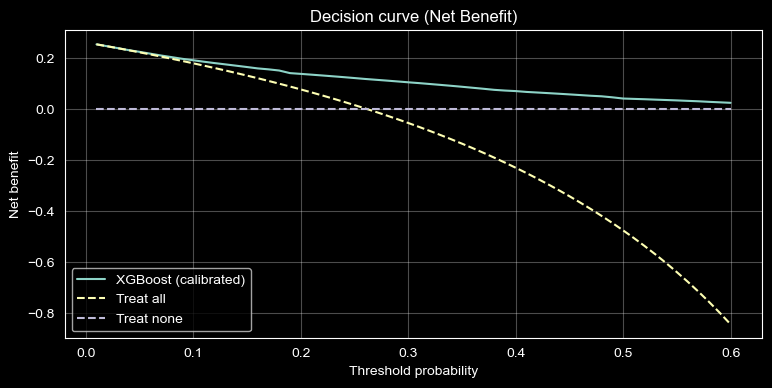

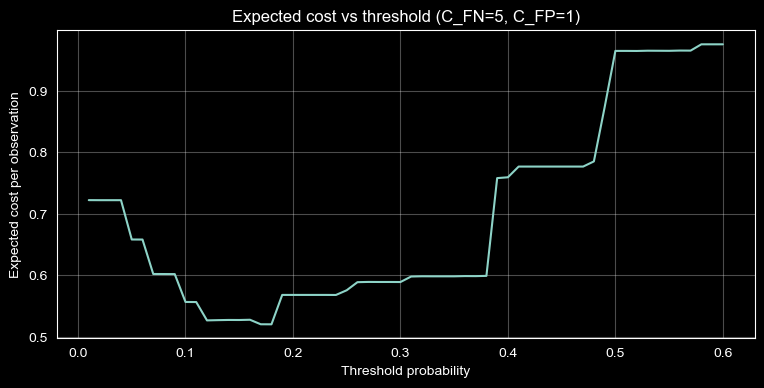

In [43]:
# =============================================================================
# 7.5 Decision curves (net benefit) + cost curves (screening policy)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use calibrated tree PDs if available; otherwise fall back to logistic
if "y_test" in globals() and "test_proba" in globals():
    y = np.asarray(y_test).astype(int)
    p = np.asarray(test_proba).astype(float)
    model_name = "XGBoost (calibrated)"
elif "test" in globals() and "pred_test" in globals() and "p_distress_logit" in pred_test.columns:
    # If you loaded predictions table
    y = np.asarray(pred_test[TARGET_COL]).astype(int)
    p = np.asarray(pred_test["p_distress_logit"]).astype(float)
    model_name = "Logit (probability)"
elif "test" in globals() and "TARGET_COL" in globals() and "test_proba" in globals():
    y = np.asarray(test[TARGET_COL]).astype(int)
    p = np.asarray(test_proba).astype(float)
    model_name = "Model"
else:
    raise RuntimeError("No TEST probabilities found. Run model cells first.")

def net_benefit(y_true, proba, thr):
    y_hat = (proba >= thr).astype(int)
    tp = int(((y_hat == 1) & (y_true == 1)).sum())
    fp = int(((y_hat == 1) & (y_true == 0)).sum())
    n = len(y_true)
    w = thr / max(1 - thr, 1e-12)  # harm/benefit trade-off implied by threshold
    return (tp / n) - (fp / n) * w

ths = np.linspace(0.01, 0.60, 60)
nb_model = np.array([net_benefit(y, p, t) for t in ths])

# Treat-all and treat-none baselines for decision curve analysis
prev = y.mean()
nb_all = prev - (1 - prev) * (ths / (1 - ths))
nb_none = np.zeros_like(ths)

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(ths, nb_model, label=model_name)
ax.plot(ths, nb_all, linestyle="--", label="Treat all")
ax.plot(ths, nb_none, linestyle="--", label="Treat none")
ax.set_title("Decision curve (Net Benefit)")
ax.set_xlabel("Threshold probability")
ax.set_ylabel("Net benefit")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
plt.show()

# Cost curve: expected cost under FP/FN costs
C_FN = float(globals().get("C_FN", 5.0))  # default: FN 5x as costly as FP
C_FP = float(globals().get("C_FP", 1.0))

def expected_cost(y_true, proba, thr, c_fn=C_FN, c_fp=C_FP):
    y_hat = (proba >= thr).astype(int)
    fn = int(((y_hat == 0) & (y_true == 1)).sum())
    fp = int(((y_hat == 1) & (y_true == 0)).sum())
    return (c_fn * fn + c_fp * fp) / max(len(y_true), 1)

costs = np.array([expected_cost(y, p, t) for t in ths])
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(ths, costs)
ax.set_title(f"Expected cost vs threshold (C_FN={C_FN:g}, C_FP={C_FP:g})")
ax.set_xlabel("Threshold probability")
ax.set_ylabel("Expected cost per observation")
ax.grid(True, alpha=0.3)
plt.show()
